# Testing Molly's code

6/5/2024 | ZG

Goals:
1) Visualize runoff predicted by all RCPs using one GCM
2) Try another GCM
3) Plot annual runoff change

# Step 1: visualize runoff predicted by all RCPs using NorESM1-M

Things to figure out: 
- No need to avg GCM values, only using one
- downloading data

In [1]:
# Import packages
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import os

### Functions

In [2]:
# Function: load the dataset
def open_series(fpath_stem, which_date, which_gcm, which_rcp):
    this_fpath = fpath_stem+'{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_rcp)
    this_ds = xr.open_dataset(this_fpath)
    return this_ds

In [3]:
# Function: calculate runoff
def calc_seasonal(this_ds):
    melt1 = this_ds.melt_on_glacier_monthly
    melt2 = this_ds.melt_off_glacier_monthly
    melt3 = this_ds.liq_prcp_off_glacier_monthly
    melt4 = this_ds.liq_prcp_on_glacier_monthly
    
    this_sum = melt1.sum(dim='rgi_id').dropna(dim='time') + melt2.sum(dim='rgi_id').dropna(dim='time') + melt3.sum(dim='rgi_id').dropna(dim='time') + melt4.sum(dim='rgi_id').dropna(dim='time')
    nonzero_sum = this_sum.where(this_sum!=0, drop=True)
    nonzero_sum *= 1e-9

    return nonzero_sum

In [4]:
# Function: select a year and take the mean runoff of all gcms for this year
def season_sliced(keys, dictionary, time):
    new_df = pd.DataFrame()
    for k in keys:
        new = dictionary[k]
        new = new[time]
        new = pd.DataFrame(new)
        new_df[k] = new
    new_df['mean'] = new_df.transpose().mean()
    return new_df

In [5]:
# Make a function that calculates a given runoff value, which I can visualize later
def rtype_calc_monthly(keys, dictionary, runoff):
    dataframe = pd.DataFrame()
    for k in keys:
        rtype_gcm = dictionary[k]
        rtype = rtype_gcm[runoff]
        rtype = pd.DataFrame(rtype)
        dataframe[k] = rtype
    dataframe['mean'] = dataframe.transpose().mean()
    return dataframe

In [6]:
# Make a function that calculates a given runoff value, which I can visualize later
def rtype_calc_monthly_2vars(keys, dictionary, runoff1, runoff2):
    dataframe = pd.DataFrame()
    for k in keys:
        rtype_gcm = dictionary[k]
        rtype1 = rtype_gcm[runoff1]
        rtype2 = rtype_gcm[runoff2]
        rsum = rtype1 + rtype2
        rtype_sum = pd.DataFrame(rsum)
        dataframe[k] = rtype_sum
    dataframe['mean'] = dataframe.transpose().mean()
    return dataframe

In [7]:
# Define variables that will be used for each test
base = '/Users/ziggygoddard/Documents/summer24/'

gcm_list = ['NorESM1-M', 'CCSM4'] 

date_list = ['2024-06-05', '2024-06-06'] # export date (date I downloaded the data)

rcp_list = ['rcp26', 'rcp45', 'rcp60', 'rcp85'] # this stays the same

gcm_w60 = ['NorESM1-M', 'CCSM4'] 

all_monthly_dict = {}

# These have to be files that I have downloaded

## Try to make a mega-dictionary with all RCPs

In [8]:
# create dictionary
all_monthly_dict = {}

In [9]:
x=0
rcp = ['rcp26', 'rcp45', 'rcp60', 'rcp85']

# Iterate over all combinations of GCMs, dates, and RCP scenarios
for gcm in gcm_list:
    for date in date_list:
        for r in rcp_list:
            # Generate the file path
            filepath = base + '{}-gcm_data_{}_{}_compiled_output.nc'.format(date, gcm, r)
            # Check if the file exists
            if os.path.exists(filepath):
                # Open dataset and store in dictionary
                rcp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_rcp=r)
                k = '{}-{}'.format(gcm, r)
                all_monthly_dict[k] = rcp_value

In [10]:
x=0
rcp = ['rcp26', 'rcp45', 'rcp60', 'rcp85']

for r in rcp:
    x = 0
    for gcm in gcm_list:
        if r != 'rcp60':
            rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=r)
            k = '{}-{}'.format(gcm, r)
            all_monthly_dict[k] = rcp_value
        else:
            if gcm in gcm_w60:
                rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=r)
                k = '{}-{}'.format(gcm, r)
                all_monthly_dict[k]=rcp_value
        x += 1

In [11]:
# Define keys
keys_all = all_monthly_dict.keys()

In [12]:
all_unrolled = {}
for k in keys_all:
    calculation = calc_seasonal(all_monthly_dict[k])
    z = '{}'.format(k)
    all_unrolled[z] = calculation

Roll values for plotting

In [13]:
n_roll = 3 # this is the roll value for all the plots

dict_roll_all = {}
dict_plot_all = {}

for k in keys_all:
    season_roll = all_unrolled[k].roll(month_2d=n_roll, roll_coords=True) # check about these
    season_forplot = all_unrolled[k].roll(month_2d=n_roll, roll_coords=True) 
    name = '{}'.format(k)
    dict_roll_all[name] = season_roll
    dict_plot_all[name] = season_forplot

In [14]:
dict_roll_all

{'NorESM1-M-rcp26': <xarray.DataArray (time: 81, month_2d: 12)> Size: 4kB
 array([[1.59531441e+01, 1.86324806e+01, 2.19926033e+01, 2.74156208e+01,
         2.16765041e+01, 1.02121878e+01, 1.26358624e+01, 4.46207285e+00,
         1.36568892e+00, 1.75041020e+00, 5.01487970e+00, 1.15260735e+01],
        [1.37756577e+01, 1.62500229e+01, 2.19672470e+01, 1.63237705e+01,
         1.97306232e+01, 1.85760689e+01, 6.88086128e+00, 2.71775818e+00,
         3.81907672e-01, 1.38510182e-01, 7.86063862e+00, 9.49918079e+00],
        [1.10329409e+01, 1.75097485e+01, 1.91433907e+01, 2.01787300e+01,
         2.00208664e+01, 3.90324974e+00, 8.21485519e+00, 2.63413548e+00,
         1.42277050e+00, 4.98606741e-01, 5.36019754e+00, 1.07568293e+01],
        [1.26287155e+01, 1.79252872e+01, 2.21999722e+01, 1.89350662e+01,
         1.64800091e+01, 2.64679871e+01, 9.94981480e+00, 1.29274249e+00,
         4.59322333e-01, 2.77066499e-01, 2.56370831e+00, 7.64912367e+00],
        [1.26126223e+01, 1.74869976e+01, 2.101

Take sum over rgi id

In [15]:
# Roll and sum
rtype_all = {}
#n_roll = o # this isn't necessary anymore

for k in keys_all:
    rtype_season = all_monthly_dict[k].roll(roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_all[rtype_name] = rtype_sum

In [16]:
# # Kept returning error that invalid file path did not exist

# # Make a dictionary with all data for all GCMs for each RCP
# rcp_monthly_dict = {}

# for rcp in rcp_list:
#     rcp_dict = {}
#     x = 0
#     for date in date_list:
#         if rcp != 'rcp60':
#             rcp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm_list[0], which_rcp=rcp)
#             k = '{}-{}'.format(gcm_list[0], rcp)
#             rcp_dict[k] = rcp_value
#         else:
#             if gcm_list[0] in gcm_w60:
#                 rcp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm_list[0], which_rcp=rcp)
#                 k = '{}-{}'.format(gcm_list[0], rcp)
#                 rcp_dict[k] = rcp_value
#         x += 1
#     rcp_monthly_dict[rcp] = rcp_dict

In [17]:
# Make a dictionary with all data for all GCMs for each RCP
# Modified - ensures that only valid file paths are attempted to be opened
rcp_monthly_dict = {}

for rcp in rcp_list:
    rcp_dict = {}
    for gcm in gcm_list:
        for date in date_list:
            # Check if the RCP is not 'rcp60' or the GCM is in gcm_w60
            if rcp != 'rcp60' or gcm in gcm_w60:
                filepath = base + '{}-gcm_data_{}_{}_compiled_output.nc'.format(date, gcm, rcp)
                # Check if the file exists before attempting to open it
                if os.path.exists(filepath):
                    rcp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_rcp=rcp)
                    k = '{}-{}'.format(gcm, rcp)
                    rcp_dict[k] = rcp_value
    rcp_monthly_dict[rcp] = rcp_dict

### Calculate rcp26

In [18]:
# Make a dictionary with all data for all GCMs (this will only output one rcp!)
rcp_monthly_dict26 = {}

x=0
rcp = 'rcp26'

# Per rcp:
for gcm in gcm_list:
    if rcp != 'rcp60':
        rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
        k = '{}-{}'.format(gcm, rcp)
        rcp_monthly_dict26[k]=rcp_value
    else:
        if gcm in gcm_w60:
            rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
            k = '{}-{}'.format(gcm, rcp)
            rcp_monthly_dict26[k]=rcp_value
    x += 1

In [19]:
# need to figure out why this is only one GCM (CCSM4 in the OG code)
# replace it with NorESM1-M
# this works!

rcp_monthly_dict26['NorESM1-M-rcp26']

<xarray.Dataset> Size: 1MB
Dimensions:                       (time: 82, rgi_id: 35, month_2d: 12)
Coordinates:
  * time                          (time) float64 656B 2.02e+03 ... 2.101e+03
  * rgi_id                        (rgi_id) <U14 2kB 'RGI60-16.00495' ... 'RGI...
    hydro_year                    (time) int64 656B ...
    hydro_month                   (time) int64 656B ...
    calendar_year                 (time) int64 656B ...
    calendar_month                (time) int64 656B ...
  * month_2d                      (month_2d) int64 96B 1 2 3 4 5 ... 9 10 11 12
    calendar_month_2d             (month_2d) int64 96B ...
Data variables: (12/24)
    volume                        (time, rgi_id) float32 11kB ...
    volume_bsl                    (time, rgi_id) float32 11kB ...
    volume_bwl                    (time, rgi_id) float32 11kB ...
    area                          (time, rgi_id) float32 11kB ...
    length                        (time, rgi_id) float32 11kB ...
    calving                       (time, rgi_id) float32 11kB ...
    ...                            ...
    liq_prcp_on_glacier_monthly   (time, month_2d, rgi_id) float32 138kB ...
    snowfall_off_glacier_monthly  (time, month_2d, rgi_id) float32 138kB ...
    snowfall_on_glacier_monthly   (time, month_2d, rgi_id) float32 138kB ...
    water_level                   (rgi_id) float32 140B ...
    glen_a                        (rgi_id) float32 140B ...
    fs                            (rgi_id) float32 140B ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.6.1
    calendar:       365-day no leap
    creation_date:  2024-06-05 16:29:25

In [20]:
# Bring in your dictionary of unrolled values to find TOTAL RUNOFF (for time slice plot)
season_unroll26 = {}
for k in rcp_monthly_dict26.keys():
    calculation = calc_seasonal(rcp_monthly_dict26[k])
    z = '{}-calc'.format(k)
    season_unroll26[z] = calculation

In [21]:
# make current gcm

season_unroll26['NorESM1-M-rcp26-calc']

<xarray.DataArray (time: 81, month_2d: 12)> Size: 4kB
array([[2.74156208e+01, 2.16765041e+01, 1.02121878e+01, 1.26358624e+01,
        4.46207285e+00, 1.36568892e+00, 1.75041020e+00, 5.01487970e+00,
        1.15260735e+01, 1.59531441e+01, 1.86324806e+01, 2.19926033e+01],
       [1.63237705e+01, 1.97306232e+01, 1.85760689e+01, 6.88086128e+00,
        2.71775818e+00, 3.81907672e-01, 1.38510182e-01, 7.86063862e+00,
        9.49918079e+00, 1.37756577e+01, 1.62500229e+01, 2.19672470e+01],
       [2.01787300e+01, 2.00208664e+01, 3.90324974e+00, 8.21485519e+00,
        2.63413548e+00, 1.42277050e+00, 4.98606741e-01, 5.36019754e+00,
        1.07568293e+01, 1.10329409e+01, 1.75097485e+01, 1.91433907e+01],
       [1.89350662e+01, 1.64800091e+01, 2.64679871e+01, 9.94981480e+00,
        1.29274249e+00, 4.59322333e-01, 2.77066499e-01, 2.56370831e+00,
        7.64912367e+00, 1.26287155e+01, 1.79252872e+01, 2.21999722e+01],
       [1.66504669e+01, 1.29543285e+01, 1.41832371e+01, 2.32004833e+00,
        2.92536163e+00, 9.07695964e-02, 4.42887783e-01, 2.06725764e+00,
        9.09384632e+00, 1.26126223e+01, 1.74869976e+01, 2.10183849e+01],
       [2.32443447e+01, 1.19381008e+01, 1.12724276e+01, 6.86065531e+00,
        3.24437165e+00, 1.16792476e+00, 2.35433236e-01, 5.79282141e+00,
        5.82802200e+00, 1.36855059e+01, 1.20767708e+01, 1.79031372e+01],
       [1.64113216e+01, 1.65375652e+01, 1.56759501e+01, 3.76680446e+00,
        1.92524314e+00, 1.12035644e+00, 8.26887012e-01, 7.09274232e-01,
...
        6.03030682e+00, 5.62788248e+00, 6.21166468e+00, 1.20986881e+01],
       [1.95913887e+01, 1.27799730e+01, 1.13258810e+01, 2.06347513e+00,
        8.25775743e-01, 6.56242296e-02, 1.88678220e-01, 7.93441534e-01,
        4.31087828e+00, 4.43610191e+00, 7.75447035e+00, 1.34636726e+01],
       [1.86503944e+01, 1.52576771e+01, 1.56906834e+01, 3.55404997e+00,
        2.12695688e-01, 1.30189508e-01, 2.00043947e-01, 4.08494443e-01,
        4.30576992e+00, 4.67165184e+00, 7.36235428e+00, 1.24875288e+01],
       [8.40169048e+00, 1.43261251e+01, 5.54089355e+00, 4.39857006e+00,
        1.17201972e+00, 1.47318229e-01, 2.71192670e-01, 2.79885721e+00,
        3.94931388e+00, 5.98170185e+00, 7.25879478e+00, 1.16616564e+01],
       [1.85513382e+01, 1.79336605e+01, 1.45736942e+01, 6.65935802e+00,
        5.69669425e-01, 3.53455245e-01, 2.97320336e-01, 1.51838994e+00,
        6.79268074e+00, 5.58001328e+00, 7.55578709e+00, 9.68803596e+00],
       [1.68777771e+01, 1.62342224e+01, 8.71081066e+00, 5.22659302e+00,
        1.10336936e+00, 1.25966871e+00, 9.37315047e-01, 2.74804711e+00,
        1.90454245e+00, 7.38156796e+00, 9.78042221e+00, 1.06084518e+01],
       [1.95065937e+01, 1.09796982e+01, 1.08279562e+01, 5.52420020e-01,
        1.29350817e+00, 1.18973923e+00, 6.67591169e-02, 1.66108048e+00,
        3.12016535e+00, 5.52272272e+00, 7.72521400e+00, 1.29990320e+01]],
      dtype=float32)
Coordinates:
  * time               (time) float64 648B 2.02e+03 2.021e+03 ... 2.1e+03
    hydro_year         (time) int64 648B 2020 2021 2022 2023 ... 2098 2099 2100
    hydro_month        (time) int64 648B 10 10 10 10 10 10 ... 10 10 10 10 10 10
    calendar_year      (time) int64 648B 2020 2021 2022 2023 ... 2098 2099 2100
    calendar_month     (time) int64 648B 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
  * month_2d           (month_2d) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    calendar_month_2d  (month_2d) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [22]:
# define keys to use in next step
keys26 = season_unroll26.keys()

In [23]:
# Roll coordinates!
## Let's try directly assigning the coordinate used for plotting?
#roll_value = -3 # we don't want to set roll values here
#n_roll = roll_value

dict_roll26 = {}
dict_plot26 = {}

for k in keys26:
    season_roll = season_unroll26[k].roll(month_2d=n_roll, roll_coords=False) # this has to be false
    season_forplot = season_unroll26[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll26[name] = season_roll
    dict_plot26[name] = season_forplot

In [24]:
# Roll and sum
rtype_roll26 = {}
#n_roll = -roll_value

for k in rcp_monthly_dict26.keys():
    rtype_season = rcp_monthly_dict26[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll26[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [25]:
rtype_roll26.keys()

dict_keys(['NorESM1-M-rcp26', 'CCSM4-rcp26'])

In [26]:
rtype_calc_s26 = {}
rtype_calc_e26 = {}

for k in rtype_roll26.keys():
    df_key = rtype_roll26[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s26[calc_name] = df_m_s

for k in rtype_roll26.keys():
    df_key = rtype_roll26[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e26[calc_name] = df_m_e

In [27]:
# IN USE: This is used for visualization of the 6-rolled hydro months, turns it into calendar months w/shift
# MODIFICATION: originally, roll(month_2d=-3, roll_coords=True); however, in new version month_2d=0, so not necessary to include
season_roll2 = season_unroll26['NorESM1-M-rcp26-calc'].roll(month_2d=n_roll, roll_coords=True)

In [28]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll26['NorESM1-M-rcp26-calc']
index2 = index1['month_2d']

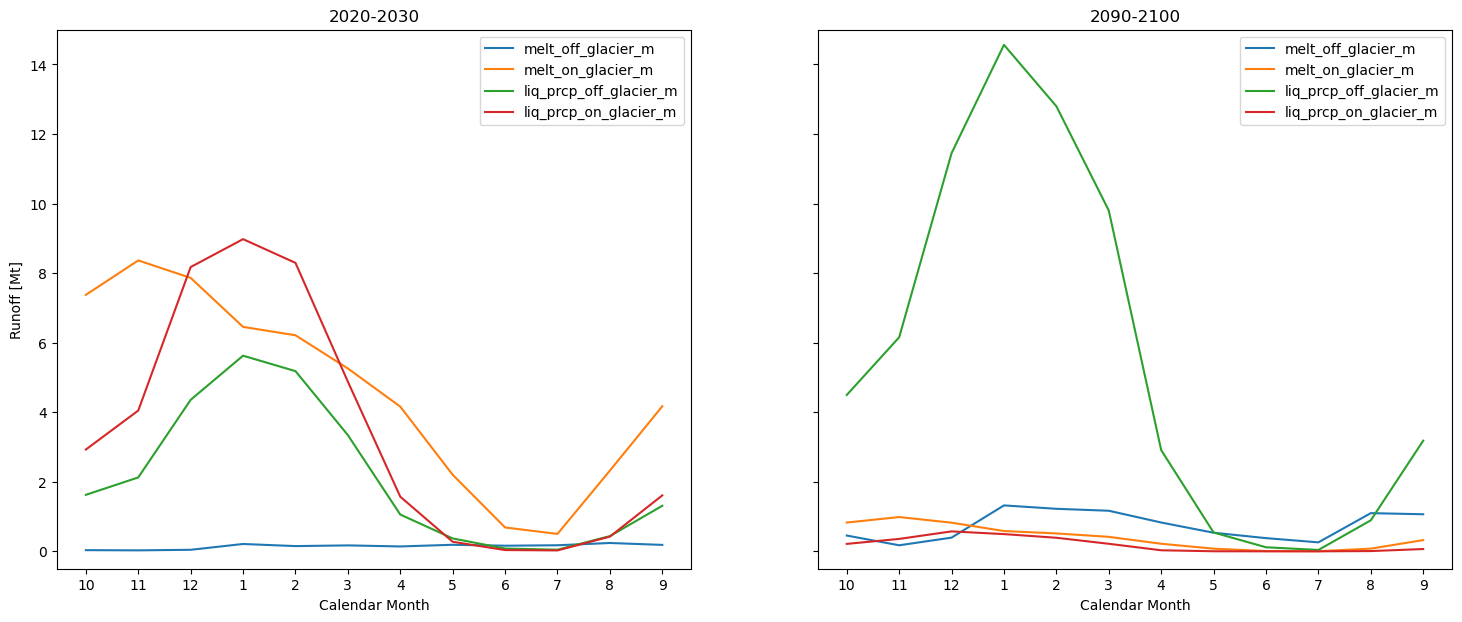

In [29]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s26.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s26, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e26, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)
    
ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

plt.ylim([-0.5,15]);

Why do the graphs above start at month 10? They do in Molly's notebook as well (come back to this)

### Calculate rcp45

In [30]:
# Make a dictionary with all data for all GCMs (this will only output one rcp!)
rcp_monthly_dict45 = {}

x=0
rcp = 'rcp45'

# Per rcp:
for gcm in gcm_list:
    if rcp != 'rcp60':
        rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
        k = '{}-{}'.format(gcm, rcp)
        rcp_monthly_dict45[k]=rcp_value
    else:
        if gcm in gcm_w60:
            rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
            k = '{}-{}'.format(gcm, rcp)
            rcp_monthly_dict45[k]=rcp_value
    x += 1

In [31]:
# Bring in your dictionary of unrolled values
season_unroll45 = {}
for k in rcp_monthly_dict45.keys():
    calculation = calc_seasonal(rcp_monthly_dict45[k])
    z = '{}-calc'.format(k)
    season_unroll45[z] = calculation

In [32]:
# define keys to use in next step
keys45 = season_unroll45.keys()

In [33]:
# Roll coordinates!

dict_roll45 = {}
dict_plot45 = {}

for k in keys45:
    season_roll = season_unroll45[k].roll(month_2d=n_roll, roll_coords=False)
    season_forplot = season_unroll45[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll45[name] = season_roll
    dict_plot45[name] = season_forplot

In [34]:
# Roll and sum
rtype_roll45 = {}

for k in rcp_monthly_dict45.keys():
    rtype_season = rcp_monthly_dict45[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll45[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [35]:
rtype_roll45.keys()

dict_keys(['NorESM1-M-rcp45', 'CCSM4-rcp45'])

In [36]:
rtype_calc_s45 = {}
rtype_calc_e45 = {}

for k in rtype_roll45.keys():
    df_key = rtype_roll45[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s45[calc_name] = df_m_s

for k in rtype_roll45.keys():
    df_key = rtype_roll45[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e45[calc_name] = df_m_e
    

In [37]:
# IN USE: This is used for visualization of the 6-rolled hydro months, turns it into calendar months w/shift
season_roll2 = season_unroll45['NorESM1-M-rcp45-calc'].roll(month_2d=n_roll, roll_coords=True)

In [38]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll45['NorESM1-M-rcp45-calc']
index2 = index1['month_2d']

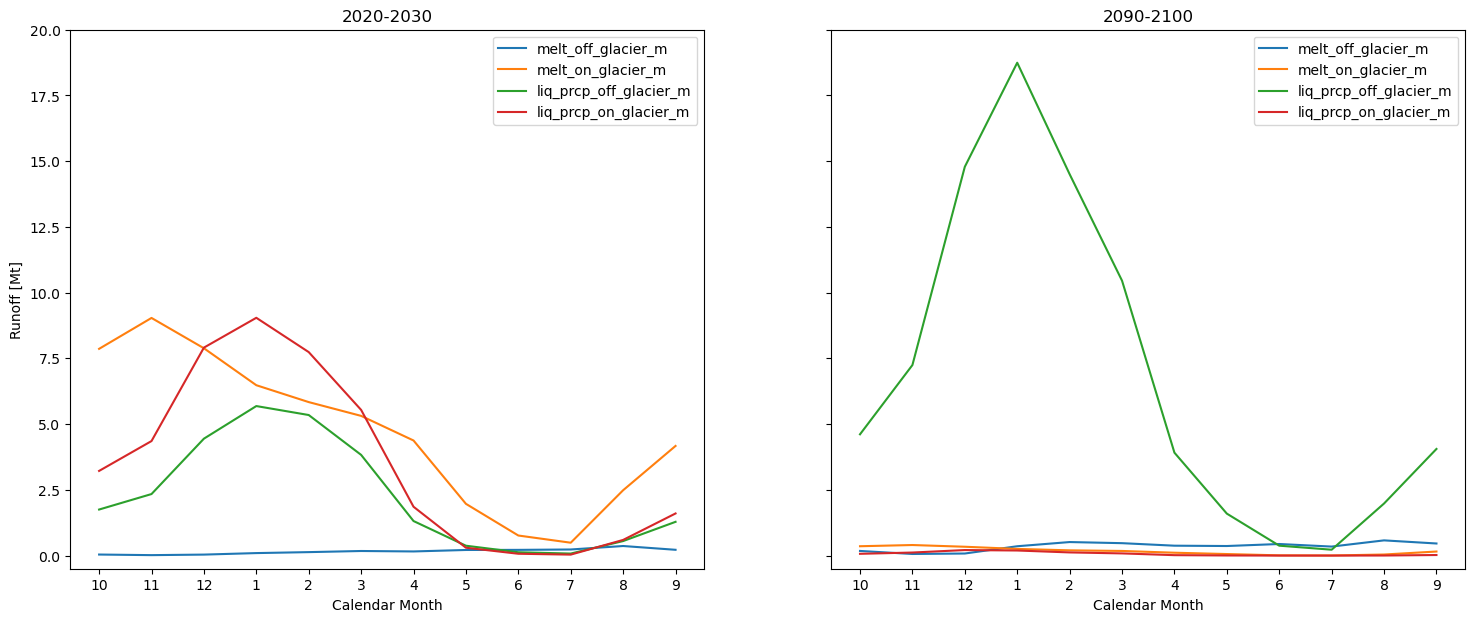

In [39]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s45.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s45, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e45, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)
    
ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();
    
plt.ylim([-0.5,20]);

These plots look different than Molly's (later peak runoff)

### Calculate rcp60

In [40]:
# Make a dictionary with all data for all GCMs (this will only output one rcp!)
rcp_monthly_dict60 = {}

x=0
rcp = 'rcp60'

# Per rcp:
for gcm in gcm_list:
    if rcp != 'rcp60':
        rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
        k = '{}-{}'.format(gcm, rcp)
        rcp_monthly_dict60[k]=rcp_value
    else:
        if gcm in gcm_w60:
            rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
            k = '{}-{}'.format(gcm, rcp)
            rcp_monthly_dict60[k]=rcp_value
    x += 1

In [41]:
# Bring in your dictionary of unrolled values
season_unroll60 = {}
for k in rcp_monthly_dict60.keys():
    calculation = calc_seasonal(rcp_monthly_dict60[k])
    z = '{}-calc'.format(k)
    season_unroll60[z] = calculation

In [42]:
# define keys to use in next step
keys60 = season_unroll60.keys()

In [43]:
# Roll coordinates!

dict_roll60 = {}
dict_plot60 = {}

for k in keys60:
    season_roll = season_unroll60[k].roll(month_2d=n_roll, roll_coords=False)
    season_forplot = season_unroll60[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll60[name] = season_roll
    dict_plot60[name] = season_forplot

In [44]:
# Roll and sum
rtype_roll60 = {}

for k in rcp_monthly_dict60.keys():
    rtype_season = rcp_monthly_dict60[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll60[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [45]:
rtype_roll60.keys()

dict_keys(['NorESM1-M-rcp60', 'CCSM4-rcp60'])

In [46]:
rtype_calc_s60 = {}
rtype_calc_e60 = {}

for k in rtype_roll60.keys():
    df_key = rtype_roll60[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s60[calc_name] = df_m_s

for k in rtype_roll60.keys():
    df_key = rtype_roll60[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e60[calc_name] = df_m_e
    

In [47]:
# IN USE: This is used for visualization of the 6-rolled hydro months, turns it into calendar months w/shift
season_roll2 = season_unroll60['NorESM1-M-rcp60-calc'].roll(month_2d=n_roll, roll_coords=True)

In [48]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll60['NorESM1-M-rcp60-calc']
index2 = index1['month_2d']

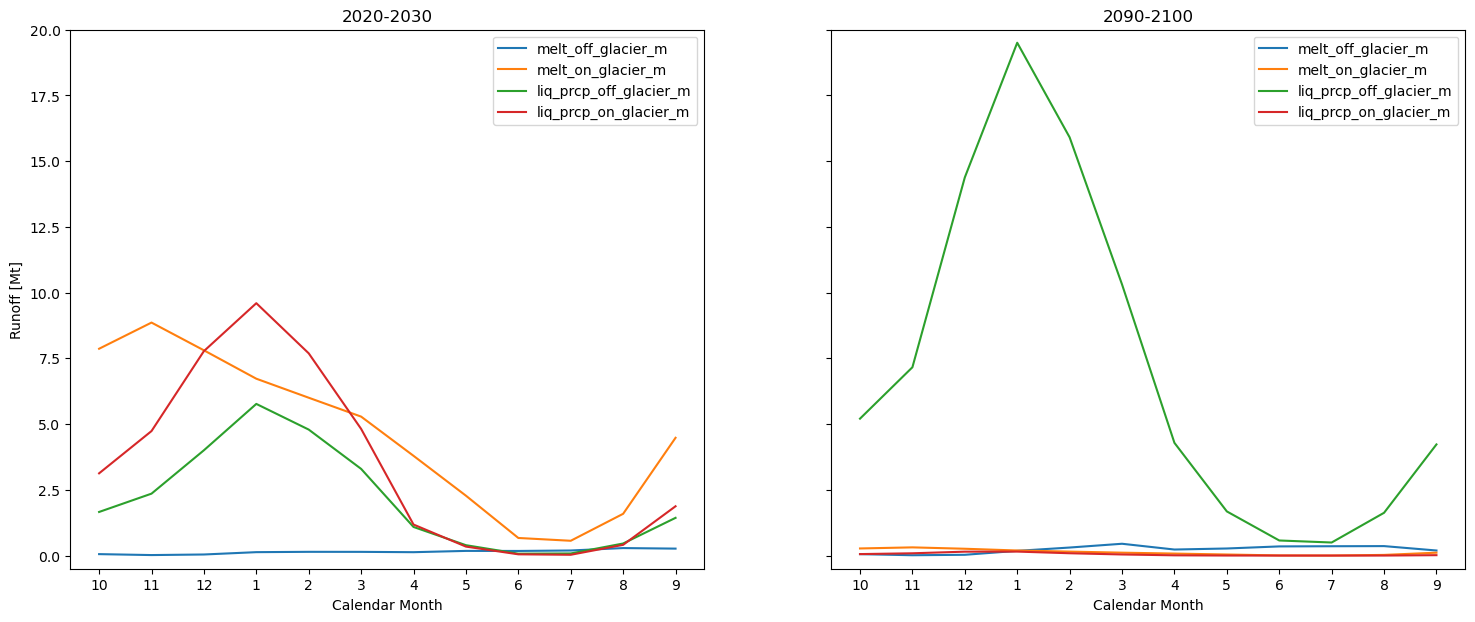

In [49]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s60.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s60, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e60, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)

ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

plt.ylim([-0.5,20]);

### Calculate rcp85

In [50]:
# Make a dictionary with all data for all GCMs (this will only output one rcp!)
rcp_monthly_dict85 = {}

x=0
rcp = 'rcp85'

# Per rcp:
for gcm in gcm_list:
    if rcp != 'rcp60':
        rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
        k = '{}-{}'.format(gcm, rcp)
        rcp_monthly_dict85[k]=rcp_value
    else:
        if gcm in gcm_w60:
            rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
            k = '{}-{}'.format(gcm, rcp)
            rcp_monthly_dict85[k]=rcp_value
    x += 1

In [51]:
# Bring in your dictionary of unrolled values
season_unroll85 = {}
for k in rcp_monthly_dict85.keys():
    calculation = calc_seasonal(rcp_monthly_dict85[k])
    z = '{}-calc'.format(k)
    season_unroll85[z] = calculation

In [52]:
# define keys to use in next step
keys85 = season_unroll85.keys()

In [53]:
# Roll coordinates!

dict_roll85 = {}
dict_plot85 = {}

for k in keys85:
    season_roll = season_unroll85[k].roll(month_2d=n_roll, roll_coords=False)
    season_forplot = season_unroll85[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll85[name] = season_roll
    dict_plot85[name] = season_forplot

In [54]:
# Roll and sum
rtype_roll85 = {}

for k in rcp_monthly_dict85.keys():
    rtype_season = rcp_monthly_dict85[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll85[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [55]:
rtype_roll85.keys()

dict_keys(['NorESM1-M-rcp85', 'CCSM4-rcp85'])

In [56]:
rtype_calc_s85 = {}
rtype_calc_e85 = {}

for k in rtype_roll85.keys():
    df_key = rtype_roll85[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s85[calc_name] = df_m_s

for k in rtype_roll85.keys():
    df_key = rtype_roll85[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e85[calc_name] = df_m_e
    

In [57]:
# IN USE: This is used for visualization of the 6-rolled hydro months, turns it into calendar months w/shift
season_roll2 = season_unroll85['NorESM1-M-rcp85-calc'].roll(month_2d=n_roll, roll_coords=True)

In [58]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll85['NorESM1-M-rcp85-calc']
index2 = index1['month_2d']

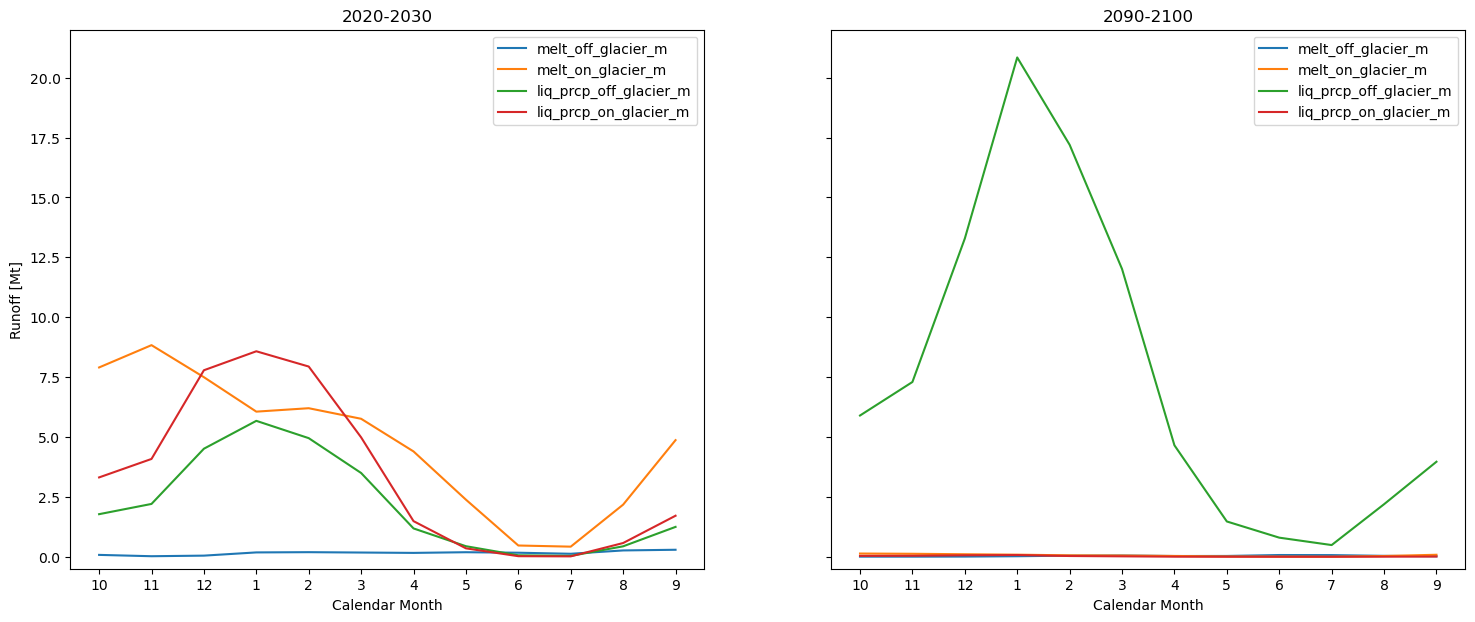

In [59]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s85.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s85, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e85, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)
    
ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

plt.ylim([-0.5,22]);

## Visualize time slices!

In [60]:
key_dict = {}

key_dict['rcp26'] = season_unroll26.keys()
key_dict['rcp45'] = season_unroll45.keys()
key_dict['rcp60'] = season_unroll60.keys()
key_dict['rcp85'] = season_unroll85.keys()

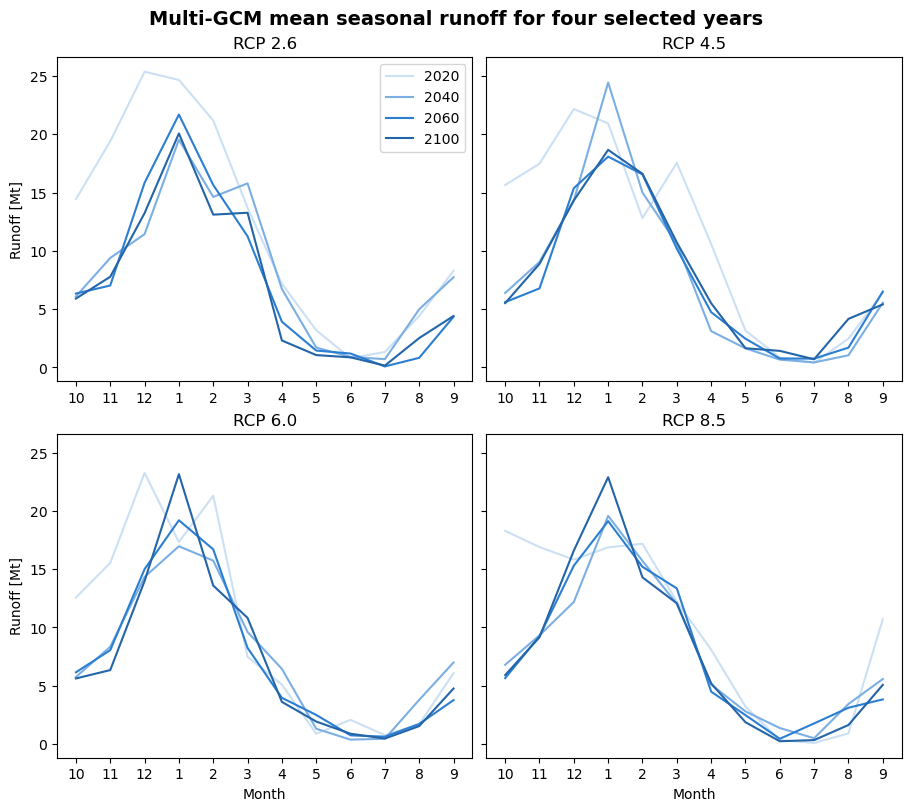

In [64]:
# Let's try to get this to show each GCM as well as means!
time = [0, 20, 40, 80]

color_ts = ('#cce0f4', '#7bafe3', '#2b7ed1', '#2365a8')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 8), sharey=True, constrained_layout = True)

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['rcp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax1.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['rcp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax2.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['rcp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax3.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1
    
t_idx=0
for t in time:
    season_t = season_sliced(key_dict['rcp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax4.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

ax1.set(xticks = season_roll['month_2d'].values,
        xticklabels = season_roll2['month_2d'].values,
        title = 'RCP 2.6',
        ylabel = 'Runoff [Mt]');
ax2.set(xticks = season_roll['month_2d'].values,
        xticklabels = season_roll2['month_2d'].values,
        title = 'RCP 4.5');
ax3.set(xticks = season_roll['month_2d'].values,
        ylabel = 'Runoff [Mt]',
        xticklabels = season_roll2['month_2d'].values,
        title = 'RCP 6.0',
        xlabel = 'Month');
ax4.set(xticks = season_roll['month_2d'].values,
        xticklabels = season_roll2['month_2d'].values,
        title = 'RCP 8.5',
        xlabel = 'Month');
ax1.legend();

plt.suptitle('Multi-GCM mean seasonal runoff for four selected years', fontweight = 'bold', fontsize = 14);

This figure is wrong; the data is 7 months offset

## Compiled decadal runoff by RCP

I want to figure out how to add a legend to these plots.

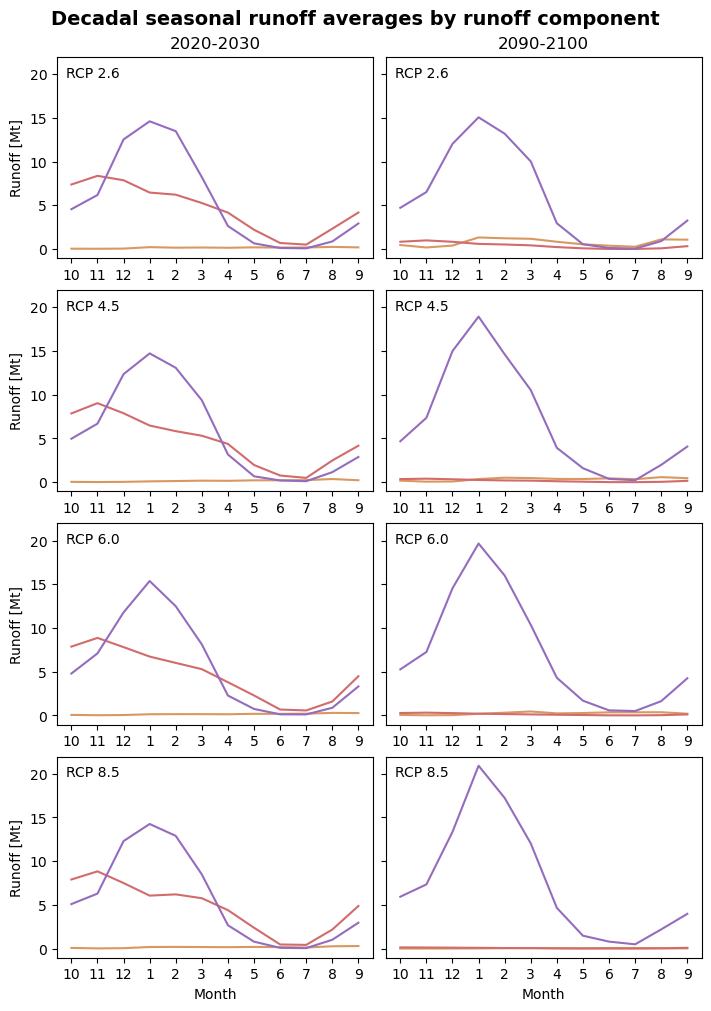

In [65]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m']
sum_vars = ['liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(7, 10), sharey=True, constrained_layout=True)

color_pr = '#946cbd'
color_m = ('#d9985f', '#d16b6c')

s_keys = rtype_calc_s26.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s26, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e26, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax2.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s26, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e26, sum_vars[0], sum_vars[1])
xvals = index2
ax1.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax2.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

s_keys = rtype_calc_s45.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s45, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e45, r)
    xvals = index2
    ax3.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax4.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s45, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e45, sum_vars[0], sum_vars[1])
xvals = index2
ax3.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax4.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

s_keys = rtype_calc_s60.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s60, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e60, r)
    xvals = index2
    ax5.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax6.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s60, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e60, sum_vars[0], sum_vars[1])
xvals = index2
ax5.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax6.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

s_keys = rtype_calc_s85.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s85, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e85, r)
    xvals = index2
    ax7.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax8.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s85, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e85, sum_vars[0], sum_vars[1])
xvals = index2
ax7.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax8.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

ax1.set(ylabel='Runoff [Mt]', title='2020-2030') # this title and the next one are overwritten by my addition
ax2.set(title='2090-2100')
ax3.set(ylabel='Runoff [Mt]')
ax5.set(ylabel='Runoff [Mt]')
ax7.set(ylabel='Runoff [Mt]', xlabel='Month')
ax8.set(xlabel='Month')

# THIS WORKS
for ax in (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8):
    ax.set(xticks=season_roll['month_2d'].values,
           xticklabels=season_roll2['month_2d'].values,  # here, we want calendar year values
           )

ax1.text(0.03, 0.9, 'RCP 2.6', transform=ax1.transAxes)
ax2.text(0.03, 0.9, 'RCP 2.6', transform=ax2.transAxes)
ax3.text(0.03, 0.9, 'RCP 4.5', transform=ax3.transAxes)
ax4.text(0.03, 0.9, 'RCP 4.5', transform=ax4.transAxes)
ax5.text(0.03, 0.9, 'RCP 6.0', transform=ax5.transAxes)
ax6.text(0.03, 0.9, 'RCP 6.0', transform=ax6.transAxes)
ax7.text(0.03, 0.9, 'RCP 8.5', transform=ax7.transAxes)
ax8.text(0.03, 0.9, 'RCP 8.5', transform=ax8.transAxes)

plt.suptitle('Decadal seasonal runoff averages by runoff component', fontweight='bold', fontsize=14)

plt.show()


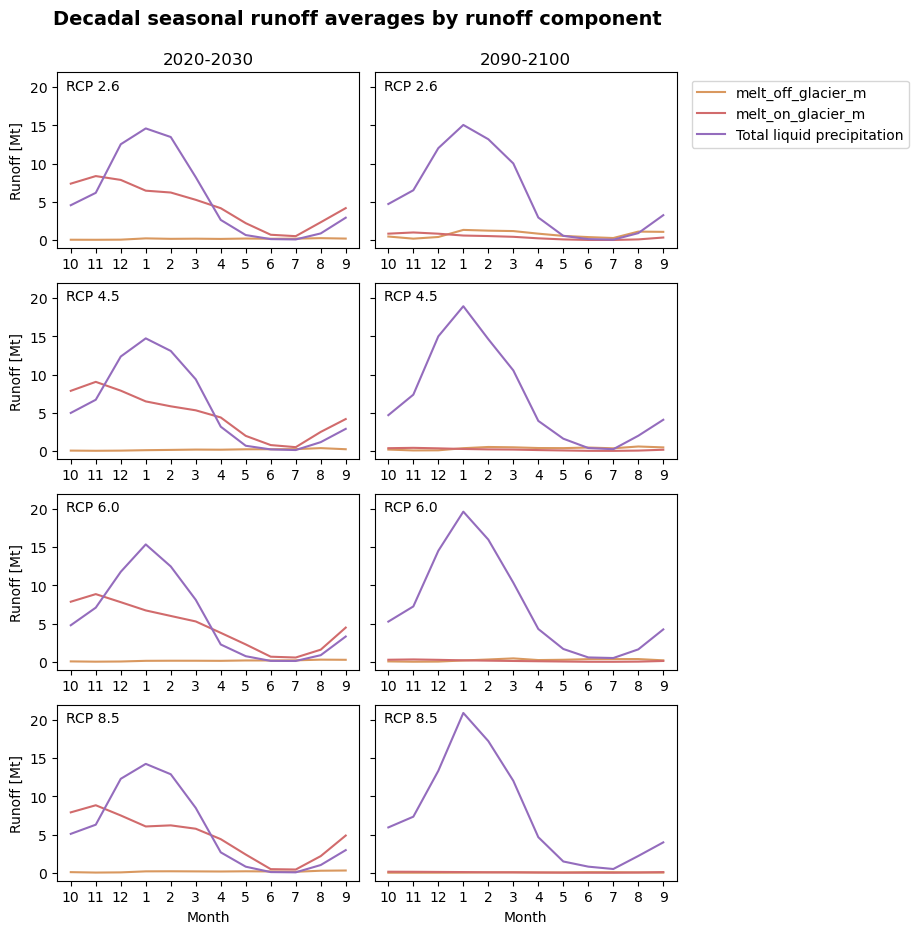

In [66]:
# this code is from ChatGPT

import matplotlib.pyplot as plt

# Define the runoff variables and colors
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m']
sum_vars = ['liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
color_pr = '#946cbd'
color_m = ['#d9985f', '#d16b6c']

# Create subplots with shared y-axis
fig, axes = plt.subplots(4, 2, figsize=(8, 10.5), sharey=True)
(ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8) = axes

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.2)

# Plotting function to avoid repetition
def plot_runoff(ax, rtype_calc_s, rtype_calc_e, s_keys, rtype_label):
    ct = 0
    for r in runoff_variables:
        runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s, r)
        runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e, r)
        xvals = index2
        ax[0].plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
        ax[1].plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
        ct += 1
    runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s, sum_vars[0], sum_vars[1])
    runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e, sum_vars[0], sum_vars[1])
    ax[0].plot(xvals, runoff_s['mean'], label='Total liquid precipitation', color=color_pr)
    ax[1].plot(xvals, runoff_e['mean'], label='Total liquid precipitation', color=color_pr)
    ax[0].set(ylabel='Runoff [Mt]')
    ax[0].text(0.03, 0.9, rtype_label, transform=ax[0].transAxes)
    ax[1].text(0.03, 0.9, rtype_label, transform=ax[1].transAxes)

# Plot each RCP scenario
plot_runoff([ax1, ax2], rtype_calc_s26, rtype_calc_e26, rtype_calc_s26.keys(), 'RCP 2.6')
plot_runoff([ax3, ax4], rtype_calc_s45, rtype_calc_e45, rtype_calc_s45.keys(), 'RCP 4.5')
plot_runoff([ax5, ax6], rtype_calc_s60, rtype_calc_e60, rtype_calc_s60.keys(), 'RCP 6.0')
plot_runoff([ax7, ax8], rtype_calc_s85, rtype_calc_e85, rtype_calc_s85.keys(), 'RCP 8.5')

# Set titles for the columns
ax1.set(title='2020-2030')
ax2.set(title='2090-2100')

# Set x-axis labels and ticks
for ax in (ax7, ax8):
    ax.set(xlabel='Month')
for ax in (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8):
    ax.set(xticks=season_roll['month_2d'].values, xticklabels=season_roll2['month_2d'].values)

# Add a single legend to the right of the plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.19, 0.84), borderaxespad=0.)

# Add a super title with adjusted vertical position
fig.suptitle('Decadal seasonal runoff averages by runoff component', fontweight='bold', fontsize=14, y=0.94)

plt.show()

### Plot of relative contribution on decade scale

In [67]:
# Set up the dictionaries with values to use in the summing function
s_keys_dict = {}
s_keys_dict['rcp26'] = rtype_calc_s26.keys()
s_keys_dict['rcp45'] = rtype_calc_s45.keys()
s_keys_dict['rcp60'] = rtype_calc_s60.keys()
s_keys_dict['rcp85'] = rtype_calc_s85.keys()

rtype_calc_dict_s = {}
rtype_calc_dict_s['rcp26'] = rtype_calc_s26
rtype_calc_dict_s['rcp45'] = rtype_calc_s45
rtype_calc_dict_s['rcp60'] = rtype_calc_s60
rtype_calc_dict_s['rcp85'] = rtype_calc_s85

rtype_calc_dict_e = {}
rtype_calc_dict_e['rcp26'] = rtype_calc_e26
rtype_calc_dict_e['rcp45'] = rtype_calc_e45
rtype_calc_dict_e['rcp60'] = rtype_calc_e60
rtype_calc_dict_e['rcp85'] = rtype_calc_e85

In [68]:
rcp = ('rcp26', 'rcp45', 'rcp60', 'rcp85')

all_rcp_dict_s = {}

for r in rcp:
    melt_on = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_s[r], 'melt_on_glacier_m')
    melt_off = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_s[r], 'melt_off_glacier_m')
    liq = rtype_calc_monthly_2vars(s_keys_dict[r], rtype_calc_dict_s[r], 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m')
    summed = melt_on + melt_off + liq
    m_on_name = 'm-on-{}'.format(r)
    m_off_name = 'm-off-{}'.format(r)
    liq_name = 'liq-{}'.format(r)
    sum_name = 'sum-{}'.format(r)
    all_rcp_dict_s[m_on_name] = melt_on
    all_rcp_dict_s[m_off_name] = melt_off
    all_rcp_dict_s[liq_name] = liq
    all_rcp_dict_s[sum_name] = summed

all_rcp_dict_e = {}

for r in rcp:
    melt_on = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_e[r], 'melt_on_glacier_m')
    melt_off = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_e[r], 'melt_off_glacier_m')
    liq = rtype_calc_monthly_2vars(s_keys_dict[r], rtype_calc_dict_e[r], 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m')
    summed = melt_on + melt_off + liq
    m_on_name = 'm-on-{}'.format(r)
    m_off_name = 'm-off-{}'.format(r)
    liq_name = 'liq-{}'.format(r)
    sum_name = 'sum-{}'.format(r)
    all_rcp_dict_e[m_on_name] = melt_on
    all_rcp_dict_e[m_off_name] = melt_off
    all_rcp_dict_e[liq_name] = liq
    all_rcp_dict_e[sum_name] = summed

Text(0.5, 1.0, 'RCP 8.5: 2090-2100')

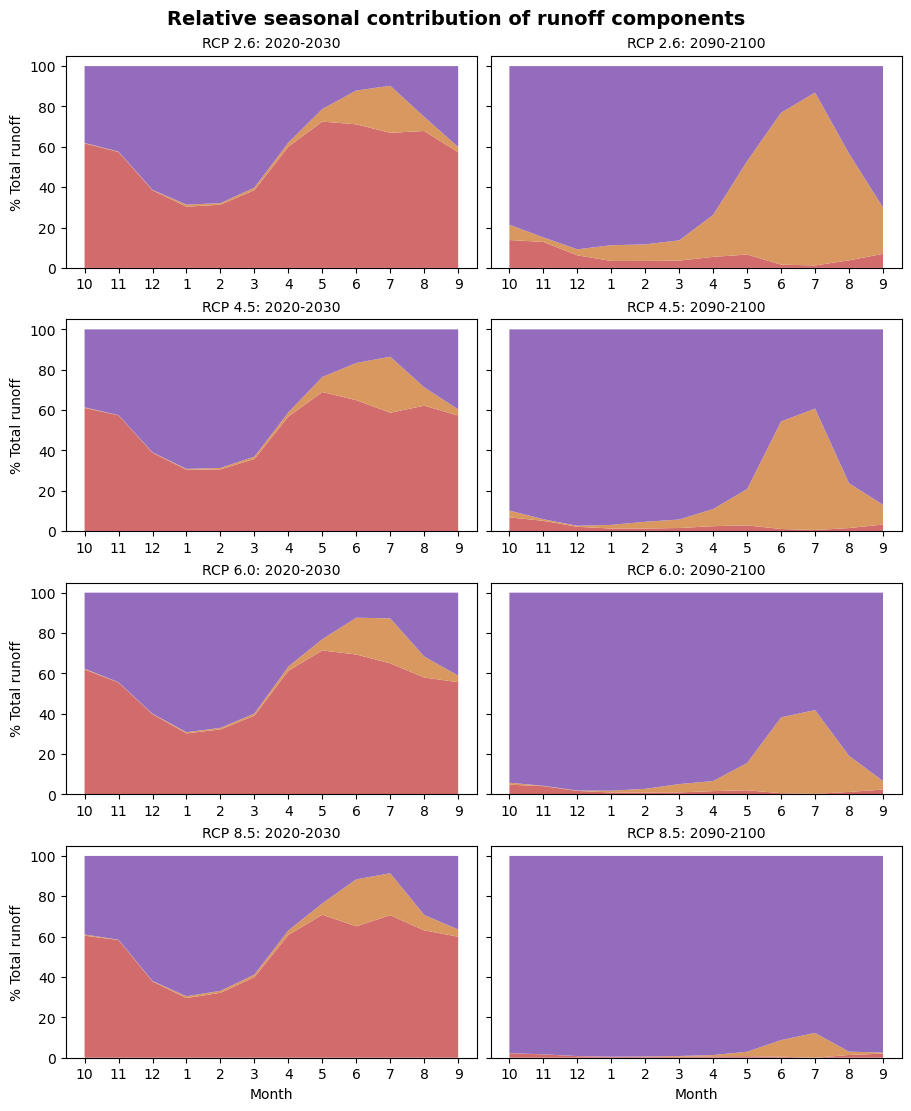

In [69]:
# Graph of relative importance of runoff for each part of the seasonal cycle (decade 1 and last)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(9, 11), sharey=True, constrained_layout = True);

color_pr = '#946cbd'
color_m = ('#d9985f', '#d16b6c')

xvals = index2

# RCP 2.6
rcp_key = 'rcp26'
ax1.stackplot(xvals, all_rcp_dict_s['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_s['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_s['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax2.stackplot(xvals, all_rcp_dict_e['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_e['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_e['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# RCP4.5
rcp_key = 'rcp45'
ax3.stackplot(xvals, all_rcp_dict_s['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_s['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_s['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax4.stackplot(xvals, all_rcp_dict_e['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_e['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_e['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# RCP6.0
rcp_key = 'rcp60'
ax5.stackplot(xvals, all_rcp_dict_s['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_s['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_s['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax6.stackplot(xvals, all_rcp_dict_e['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_e['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_e['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# RCP85
rcp_key = 'rcp85'
ax7.stackplot(xvals, all_rcp_dict_s['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_s['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_s['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax8.stackplot(xvals, all_rcp_dict_e['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_e['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_e['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

#ax1.legend(bbox_to_anchor=(0.44, 0.95));

plt.suptitle('Relative seasonal contribution of runoff components', fontweight = 'bold', fontsize = 14);

ax1.set(ylabel='% Total runoff', title='2020-2030')
ax2.set(title='2090-2100')
ax3.set(ylabel='% Total runoff')
ax5.set(ylabel='% Total runoff')
ax7.set(ylabel='% Total runoff', xlabel = 'Month')
ax8.set(xlabel = 'Month')
# THIS WORKS
for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values #here, we want calendar year values
          );
# Add RCP labels as titles (from chatgpt)
ax1.set_title('RCP 2.6: 2020-2030', fontsize=10)
ax2.set_title('RCP 2.6: 2090-2100', fontsize=10)
ax3.set_title('RCP 4.5: 2020-2030', fontsize=10)
ax4.set_title('RCP 4.5: 2090-2100', fontsize=10)
ax5.set_title('RCP 6.0: 2020-2030', fontsize=10)
ax6.set_title('RCP 6.0: 2090-2100', fontsize=10)
ax7.set_title('RCP 8.5: 2020-2030', fontsize=10)
ax8.set_title('RCP 8.5: 2090-2100', fontsize=10)

#plt.savefig('Figures/Seasonal/Decade_av/4x2_relative_importance_newMay4.png', bbox_inches='tight')

# Step 2: try with another GCM

In [133]:
# This is place to add GCMs and dates; it only needs to be in one place, so I commented it out

# # Define variables that will be used for each test
# base = '/Users/ziggygoddard/Documents/summer24/'

# gcm_list = ['NorESM1-M', 'CCSM4'] # just the current gcm

# date_list = ['2024-06-05', '2024-06-06'] # export date (date I downloaded the data)

# rcp_list = ['rcp26', 'rcp45', 'rcp60', 'rcp85'] # this stays the same

# gcm_w60 = ['NorESM1-M', 'CCSM4'] 

# all_monthly_dict = {}

# # These have to be files that I have downloaded

## Try to make a mega-dictionary with all RCPs

In [70]:
# create dictionary
all_monthly_dict = {}

In [71]:
rcp_monthly_dict = {}

for rcp in rcp_list:
    rcp_dict = {}
    for i, gcm in enumerate(gcm_list):
        date = date_list[i]  # Ensure the date corresponds to the correct GCM
        filepath = f"{base}{date}-gcm_data_{gcm}_{rcp}_compiled_output.nc"
        print(f"Trying to open file: {filepath}")
        if rcp != 'rcp60':
            rcp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_rcp=rcp)
            k = '{}-{}'.format(gcm, rcp)
            rcp_dict[k] = rcp_value
        else:
            if gcm in gcm_w60:
                rcp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_rcp=rcp)
                k = '{}-{}'.format(gcm, rcp)
                rcp_dict[k] = rcp_value
    rcp_monthly_dict[rcp] = rcp_dict

Trying to open file: /Users/ziggygoddard/Documents/summer24/2024-06-05-gcm_data_NorESM1-M_rcp26_compiled_output.nc
Trying to open file: /Users/ziggygoddard/Documents/summer24/2024-06-06-gcm_data_CCSM4_rcp26_compiled_output.nc
Trying to open file: /Users/ziggygoddard/Documents/summer24/2024-06-05-gcm_data_NorESM1-M_rcp45_compiled_output.nc
Trying to open file: /Users/ziggygoddard/Documents/summer24/2024-06-06-gcm_data_CCSM4_rcp45_compiled_output.nc
Trying to open file: /Users/ziggygoddard/Documents/summer24/2024-06-05-gcm_data_NorESM1-M_rcp60_compiled_output.nc
Trying to open file: /Users/ziggygoddard/Documents/summer24/2024-06-06-gcm_data_CCSM4_rcp60_compiled_output.nc
Trying to open file: /Users/ziggygoddard/Documents/summer24/2024-06-05-gcm_data_NorESM1-M_rcp85_compiled_output.nc
Trying to open file: /Users/ziggygoddard/Documents/summer24/2024-06-06-gcm_data_CCSM4_rcp85_compiled_output.nc


In [72]:
x=0
rcp = ['rcp26', 'rcp45', 'rcp60', 'rcp85']

for r in rcp:
    x = 0
    for gcm in gcm_list:
        if r != 'rcp60':
            rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=r)
            k = '{}-{}'.format(gcm, r)
            all_monthly_dict[k] = rcp_value
        else:
            if gcm in gcm_w60:
                rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=r)
                k = '{}-{}'.format(gcm, r)
                all_monthly_dict[k]=rcp_value
        x += 1

In [73]:
# Define keys
keys_all = all_monthly_dict.keys()

In [74]:
all_unrolled = {}
for k in keys_all:
    calculation = calc_seasonal(all_monthly_dict[k])
    z = '{}'.format(k)
    all_unrolled[z] = calculation

Roll values for plotting

In [75]:
n_roll = 3

dict_roll_all = {}
dict_plot_all = {}

for k in keys_all:
    season_roll = all_unrolled[k].roll(month_2d=n_roll, roll_coords=True)
    season_forplot = all_unrolled[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll_all[name] = season_roll
    dict_plot_all[name] = season_forplot

In [76]:
dict_roll_all

{'NorESM1-M-rcp26': <xarray.DataArray (time: 81, month_2d: 12)> Size: 4kB
 array([[1.59531441e+01, 1.86324806e+01, 2.19926033e+01, 2.74156208e+01,
         2.16765041e+01, 1.02121878e+01, 1.26358624e+01, 4.46207285e+00,
         1.36568892e+00, 1.75041020e+00, 5.01487970e+00, 1.15260735e+01],
        [1.37756577e+01, 1.62500229e+01, 2.19672470e+01, 1.63237705e+01,
         1.97306232e+01, 1.85760689e+01, 6.88086128e+00, 2.71775818e+00,
         3.81907672e-01, 1.38510182e-01, 7.86063862e+00, 9.49918079e+00],
        [1.10329409e+01, 1.75097485e+01, 1.91433907e+01, 2.01787300e+01,
         2.00208664e+01, 3.90324974e+00, 8.21485519e+00, 2.63413548e+00,
         1.42277050e+00, 4.98606741e-01, 5.36019754e+00, 1.07568293e+01],
        [1.26287155e+01, 1.79252872e+01, 2.21999722e+01, 1.89350662e+01,
         1.64800091e+01, 2.64679871e+01, 9.94981480e+00, 1.29274249e+00,
         4.59322333e-01, 2.77066499e-01, 2.56370831e+00, 7.64912367e+00],
        [1.26126223e+01, 1.74869976e+01, 2.101

Take sum over rgi id

In [77]:
rtype_all = {}

for k in keys_all:
    rtype_season = all_monthly_dict[k].roll(roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_all[rtype_name] = rtype_sum

In [78]:
# Make a dictionary with all data for all GCMs for each RCP
rcp_monthly_dict = {}

for rcp in rcp_list:
    rcp_dict = {}
    for gcm in gcm_list:
        for date in date_list:
            # Check if the RCP is not 'rcp60' or the GCM is in gcm_w60
            if rcp != 'rcp60' or gcm in gcm_w60:
                filepath = base + '{}-gcm_data_{}_{}_compiled_output.nc'.format(date, gcm, rcp)
                # Check if the file exists before attempting to open it
                if os.path.exists(filepath):
                    rcp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_rcp=rcp)
                    k = '{}-{}'.format(gcm, rcp)
                    rcp_dict[k] = rcp_value
    rcp_monthly_dict[rcp] = rcp_dict

### Calculate rcp26

In [79]:
# Make a dictionary with all data for all GCMs (this will only output one rcp!)
rcp_monthly_dict26 = {}

x=0
rcp = 'rcp26'

# Per rcp:
for gcm in gcm_list:
    if rcp != 'rcp60':
        rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
        k = '{}-{}'.format(gcm, rcp)
        rcp_monthly_dict26[k]=rcp_value
    else:
        if gcm in gcm_w60:
            rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
            k = '{}-{}'.format(gcm, rcp)
            rcp_monthly_dict26[k]=rcp_value
    x += 1

In [80]:
rcp_monthly_dict26['CCSM4-rcp26']

<xarray.Dataset> Size: 1MB
Dimensions:                       (time: 82, rgi_id: 35, month_2d: 12)
Coordinates:
  * time                          (time) float64 656B 2.02e+03 ... 2.101e+03
  * rgi_id                        (rgi_id) <U14 2kB 'RGI60-16.00495' ... 'RGI...
    hydro_year                    (time) int64 656B ...
    hydro_month                   (time) int64 656B ...
    calendar_year                 (time) int64 656B ...
    calendar_month                (time) int64 656B ...
  * month_2d                      (month_2d) int64 96B 1 2 3 4 5 ... 9 10 11 12
    calendar_month_2d             (month_2d) int64 96B ...
Data variables: (12/24)
    volume                        (time, rgi_id) float32 11kB ...
    volume_bsl                    (time, rgi_id) float32 11kB ...
    volume_bwl                    (time, rgi_id) float32 11kB ...
    area                          (time, rgi_id) float32 11kB ...
    length                        (time, rgi_id) float32 11kB ...
    calving                       (time, rgi_id) float32 11kB ...
    ...                            ...
    liq_prcp_on_glacier_monthly   (time, month_2d, rgi_id) float32 138kB ...
    snowfall_off_glacier_monthly  (time, month_2d, rgi_id) float32 138kB ...
    snowfall_on_glacier_monthly   (time, month_2d, rgi_id) float32 138kB ...
    water_level                   (rgi_id) float32 140B ...
    glen_a                        (rgi_id) float32 140B ...
    fs                            (rgi_id) float32 140B ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.6.1
    calendar:       365-day no leap
    creation_date:  2024-06-06 16:41:59

In [81]:
# Bring in your dictionary of unrolled values to find TOTAL RUNOFF (for time slice plot)
season_unroll26 = {}
for k in rcp_monthly_dict26.keys():
    calculation = calc_seasonal(rcp_monthly_dict26[k])
    z = '{}-calc'.format(k)
    season_unroll26[z] = calculation

In [82]:
# make current gcm

season_unroll26['CCSM4-rcp26-calc']

<xarray.DataArray (time: 81, month_2d: 12)> Size: 4kB
array([[2.19206314e+01, 2.07080078e+01, 1.71784325e+01, 1.71807230e+00,
        1.91689134e+00, 1.97974473e-01, 8.95277143e-01, 3.80160141e+00,
        5.05943012e+00, 1.29238672e+01, 2.01641655e+01, 2.87479210e+01],
       [2.31238480e+01, 3.33236008e+01, 2.29535770e+01, 1.38716078e+01,
        7.02272797e+00, 2.65195298e+00, 1.00460970e+00, 3.20594549e+00,
        8.65106297e+00, 1.59801502e+01, 1.70748062e+01, 2.76614799e+01],
       [3.50865555e+01, 2.53649635e+01, 1.27678881e+01, 1.25150671e+01,
        4.29380846e+00, 6.12140775e-01, 7.13368416e-01, 1.57082415e+00,
        4.36596298e+00, 1.26071434e+01, 1.64356117e+01, 2.37091503e+01],
       [6.42681551e+00, 1.75170956e+01, 8.66852093e+00, 9.91677284e+00,
        2.52544761e+00, 1.56516463e-01, 1.13092566e+00, 8.91357124e-01,
        5.54832602e+00, 8.32553768e+00, 1.53329611e+01, 1.97716942e+01],
       [2.33842812e+01, 2.03942471e+01, 9.50076294e+00, 8.12460327e+00,
        4.66752338e+00, 2.35174322e+00, 5.01374662e-01, 8.28265953e+00,
        1.10278683e+01, 1.44390383e+01, 1.54177523e+01, 2.49001980e+01],
       [3.58601112e+01, 2.73367271e+01, 1.60549316e+01, 9.33301926e+00,
        3.59225607e+00, 1.42640662e+00, 2.45447803e+00, 1.68977726e+00,
        8.66033363e+00, 1.38679094e+01, 1.48044691e+01, 1.83279762e+01],
       [1.63862953e+01, 1.45832911e+01, 1.25537434e+01, 6.56426954e+00,
        2.13239288e+00, 3.05049062e-01, 8.31392527e-01, 8.09915245e-01,
...
        6.21413374e+00, 7.56581736e+00, 7.98022079e+00, 1.16212683e+01],
       [1.97537880e+01, 1.88495464e+01, 1.43737488e+01, 4.07739258e+00,
        2.01067829e+00, 7.78351843e-01, 3.70026052e-01, 2.10199857e+00,
        6.47311020e+00, 6.11731768e+00, 5.86861897e+00, 1.85440216e+01],
       [1.25671740e+01, 1.29524879e+01, 1.24905138e+01, 5.51395273e+00,
        1.33074415e+00, 1.01374400e+00, 2.53891200e-01, 3.20993423e+00,
        6.01413202e+00, 6.20058012e+00, 8.16220379e+00, 1.19564190e+01],
       [1.46555252e+01, 9.80061436e+00, 9.23893261e+00, 4.36058044e+00,
        1.23907816e+00, 9.15246382e-02, 1.87840968e-01, 1.53758001e+00,
        5.75321054e+00, 6.71945047e+00, 8.21160030e+00, 1.85832672e+01],
       [1.75826244e+01, 1.95585995e+01, 6.92832184e+00, 7.64326429e+00,
        1.68909657e+00, 5.13996482e-01, 2.17480421e-01, 1.19473028e+00,
        2.31385899e+00, 4.85008287e+00, 8.06957912e+00, 9.78363514e+00],
       [1.30366955e+01, 1.55931625e+01, 1.23642845e+01, 4.75680971e+00,
        1.68336749e+00, 9.46903527e-01, 2.34984249e-01, 1.51194501e+00,
        3.00873446e+00, 7.72971439e+00, 9.05142975e+00, 1.44429884e+01],
       [2.06442490e+01, 1.52313900e+01, 1.57112331e+01, 4.06217003e+00,
        8.15352380e-01, 5.29701531e-01, 2.38544211e-01, 3.36977720e+00,
        5.69542837e+00, 6.28619909e+00, 7.82538080e+00, 1.34698515e+01]],
      dtype=float32)
Coordinates:
  * time               (time) float64 648B 2.02e+03 2.021e+03 ... 2.1e+03
    hydro_year         (time) int64 648B 2020 2021 2022 2023 ... 2098 2099 2100
    hydro_month        (time) int64 648B 10 10 10 10 10 10 ... 10 10 10 10 10 10
    calendar_year      (time) int64 648B 2020 2021 2022 2023 ... 2098 2099 2100
    calendar_month     (time) int64 648B 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
  * month_2d           (month_2d) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    calendar_month_2d  (month_2d) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [83]:
# define keys to use in next step
keys26 = season_unroll26.keys()

In [84]:
# Roll coordinates!
dict_roll26 = {}
dict_plot26 = {}

for k in keys26:
    season_roll = season_unroll26[k].roll(month_2d=n_roll, roll_coords=False)
    season_forplot = season_unroll26[k].roll(month_2d=n_roll, roll_coords=False) 
    name = '{}'.format(k)
    dict_roll26[name] = season_roll
    dict_plot26[name] = season_forplot

In [85]:
# Roll and sum
rtype_roll26 = {}

for k in rcp_monthly_dict26.keys():
    rtype_season = rcp_monthly_dict26[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll26[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [86]:
rtype_roll26.keys()

dict_keys(['NorESM1-M-rcp26', 'CCSM4-rcp26'])

In [87]:
rtype_calc_s26 = {}
rtype_calc_e26 = {}

for k in rtype_roll26.keys():
    df_key = rtype_roll26[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s26[calc_name] = df_m_s

for k in rtype_roll26.keys():
    df_key = rtype_roll26[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e26[calc_name] = df_m_e
    

In [88]:
season_roll2 = season_unroll26['CCSM4-rcp26-calc'].roll(month_2d=n_roll, roll_coords=True)

In [89]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll26['CCSM4-rcp26-calc']
index2 = index1['month_2d']

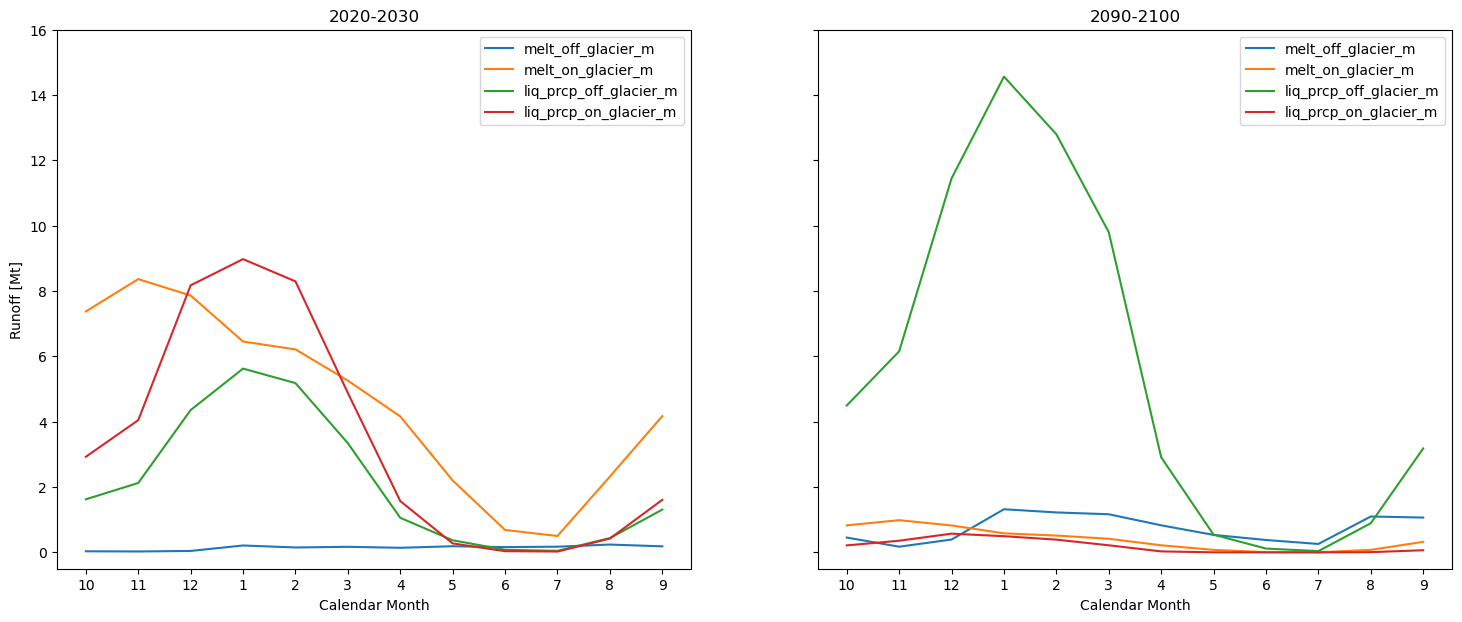

In [90]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s26.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s26, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e26, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)

ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

Aside from the temporal offset, these graphs are different than Molly's even though the GCM is the same. This is an issue.
resolved

### Calculate rcp45

In [91]:
# Make a dictionary with all data for all GCMs (this will only output one rcp!)
rcp_monthly_dict45 = {}

x=0
rcp = 'rcp45'

# Per rcp:
for gcm in gcm_list:
    if rcp != 'rcp60':
        rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
        k = '{}-{}'.format(gcm, rcp)
        rcp_monthly_dict45[k]=rcp_value
    else:
        if gcm in gcm_w60:
            rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
            k = '{}-{}'.format(gcm, rcp)
            rcp_monthly_dict45[k]=rcp_value
    x += 1

In [92]:
# Bring in your dictionary of unrolled values
season_unroll45 = {}
for k in rcp_monthly_dict45.keys():
    calculation = calc_seasonal(rcp_monthly_dict45[k])
    z = '{}-calc'.format(k)
    season_unroll45[z] = calculation

In [93]:
# define keys to use in next step
keys45 = season_unroll45.keys()

In [94]:
# Roll coordinates!
dict_roll45 = {}
dict_plot45 = {}

for k in keys45:
    season_roll = season_unroll45[k].roll(month_2d=n_roll, roll_coords=False)
    season_forplot = season_unroll45[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll45[name] = season_roll
    dict_plot45[name] = season_forplot

In [95]:
# Roll and sum
rtype_roll45 = {}

for k in rcp_monthly_dict45.keys():
    rtype_season = rcp_monthly_dict45[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll45[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [96]:
rtype_roll45.keys()

dict_keys(['NorESM1-M-rcp45', 'CCSM4-rcp45'])

In [97]:
rtype_calc_s45 = {}
rtype_calc_e45 = {}

for k in rtype_roll45.keys():
    df_key = rtype_roll45[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s45[calc_name] = df_m_s

for k in rtype_roll45.keys():
    df_key = rtype_roll45[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e45[calc_name] = df_m_e
    

In [98]:
season_roll2 = season_unroll45['CCSM4-rcp45-calc'].roll(month_2d=n_roll, roll_coords=True)

In [99]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll45['CCSM4-rcp45-calc']
index2 = index1['month_2d']

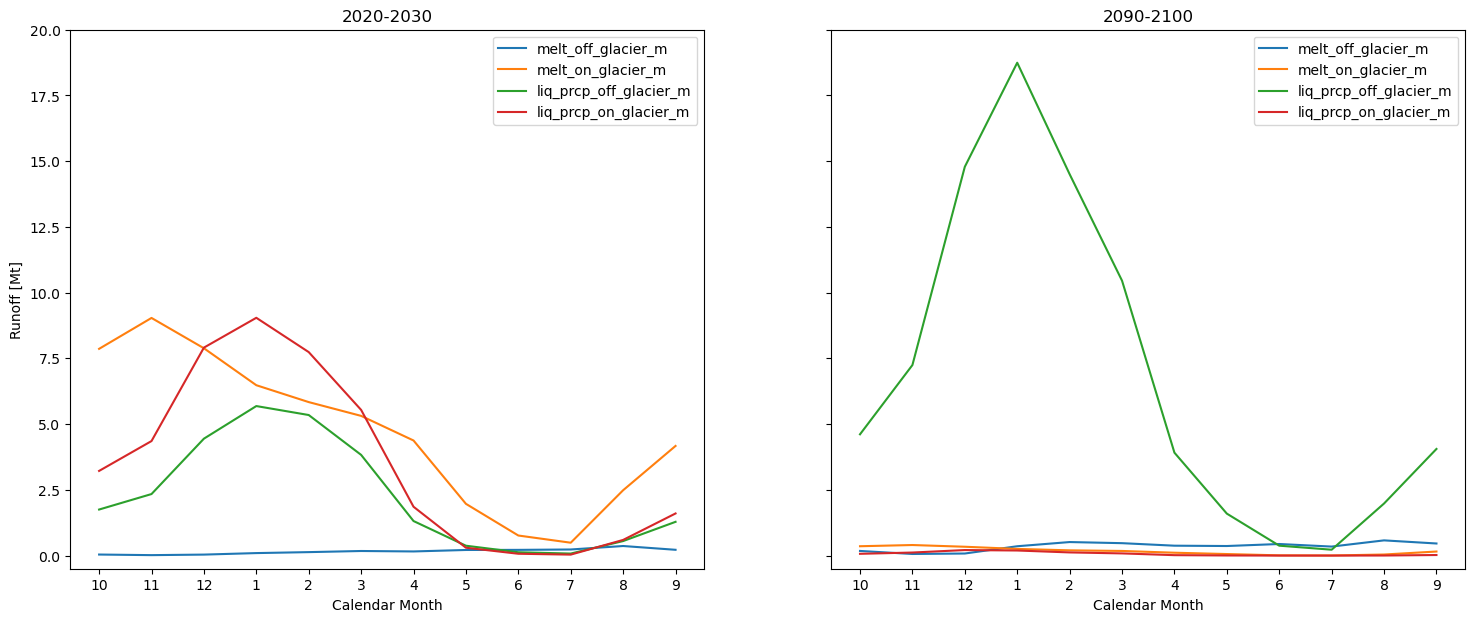

In [100]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s45.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s45, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e45, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)
    
ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

plt.ylim([-0.5,20]);

These plots look different than Molly's (later peak runoff)

### Calculate rcp60

In [101]:
# Make a dictionary with all data for all GCMs (this will only output one rcp!)
rcp_monthly_dict60 = {}

x=0
rcp = 'rcp60'

# Per rcp:
for gcm in gcm_list:
    if rcp != 'rcp60':
        rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
        k = '{}-{}'.format(gcm, rcp)
        rcp_monthly_dict60[k]=rcp_value
    else:
        if gcm in gcm_w60:
            rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
            k = '{}-{}'.format(gcm, rcp)
            rcp_monthly_dict60[k]=rcp_value
    x += 1

In [102]:
# Bring in your dictionary of unrolled values
season_unroll60 = {}
for k in rcp_monthly_dict60.keys():
    calculation = calc_seasonal(rcp_monthly_dict60[k])
    z = '{}-calc'.format(k)
    season_unroll60[z] = calculation

In [103]:
# define keys to use in next step
keys60 = season_unroll60.keys()

In [104]:
# Roll coordinates!
dict_roll60 = {}
dict_plot60 = {}

for k in keys60:
    season_roll = season_unroll60[k].roll(month_2d=n_roll, roll_coords=False)
    season_forplot = season_unroll60[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll60[name] = season_roll
    dict_plot60[name] = season_forplot

In [105]:
# Roll and sum
rtype_roll60 = {}

for k in rcp_monthly_dict60.keys():
    rtype_season = rcp_monthly_dict60[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll60[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [106]:
rtype_roll60.keys()

dict_keys(['NorESM1-M-rcp60', 'CCSM4-rcp60'])

In [107]:
rtype_calc_s60 = {}
rtype_calc_e60 = {}

for k in rtype_roll60.keys():
    df_key = rtype_roll60[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s60[calc_name] = df_m_s

for k in rtype_roll60.keys():
    df_key = rtype_roll60[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e60[calc_name] = df_m_e
    

In [108]:
# IN USE: This is used for visualization of the 6-rolled hydro months, turns it into calendar months w/shift
season_roll2 = season_unroll60['CCSM4-rcp60-calc'].roll(month_2d=n_roll, roll_coords=True)

In [109]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll60['CCSM4-rcp60-calc']
index2 = index1['month_2d']

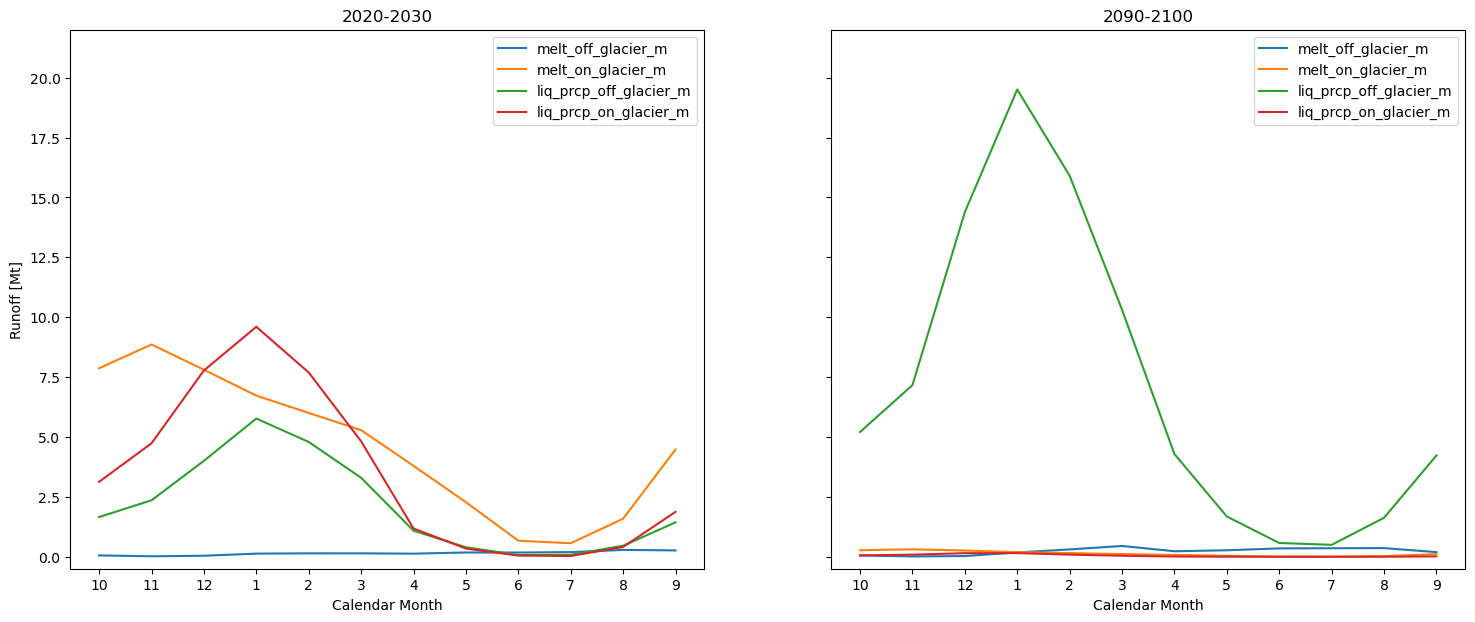

In [110]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s60.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s60, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e60, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)
    
ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

plt.ylim([-0.5,22]);

### Calculate rcp85

In [111]:
# Make a dictionary with all data for all GCMs (this will only output one rcp!)
rcp_monthly_dict85 = {}

x=0
rcp = 'rcp85'

# Per rcp:
for gcm in gcm_list:
    if rcp != 'rcp60':
        rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
        k = '{}-{}'.format(gcm, rcp)
        rcp_monthly_dict85[k]=rcp_value
    else:
        if gcm in gcm_w60:
            rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
            k = '{}-{}'.format(gcm, rcp)
            rcp_monthly_dict85[k]=rcp_value
    x += 1

In [112]:
# Bring in your dictionary of unrolled values
season_unroll85 = {}
for k in rcp_monthly_dict85.keys():
    calculation = calc_seasonal(rcp_monthly_dict85[k])
    z = '{}-calc'.format(k)
    season_unroll85[z] = calculation

In [113]:
# define keys to use in next step
keys85 = season_unroll85.keys()

In [114]:
# Roll coordinates!
dict_roll85 = {}
dict_plot85 = {}

for k in keys85:
    season_roll = season_unroll85[k].roll(month_2d=n_roll, roll_coords=False)
    season_forplot = season_unroll85[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll85[name] = season_roll
    dict_plot85[name] = season_forplot

In [115]:
# Roll and sum
rtype_roll85 = {}

for k in rcp_monthly_dict85.keys():
    rtype_season = rcp_monthly_dict85[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll85[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [116]:
rtype_roll85.keys()

dict_keys(['NorESM1-M-rcp85', 'CCSM4-rcp85'])

In [117]:
rtype_calc_s85 = {}
rtype_calc_e85 = {}

for k in rtype_roll85.keys():
    df_key = rtype_roll85[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s85[calc_name] = df_m_s

for k in rtype_roll85.keys():
    df_key = rtype_roll85[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e85[calc_name] = df_m_e
    

In [118]:
season_roll2 = season_unroll85['CCSM4-rcp85-calc'].roll(month_2d=n_roll, roll_coords=True)

In [119]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll85['CCSM4-rcp85-calc']
index2 = index1['month_2d']

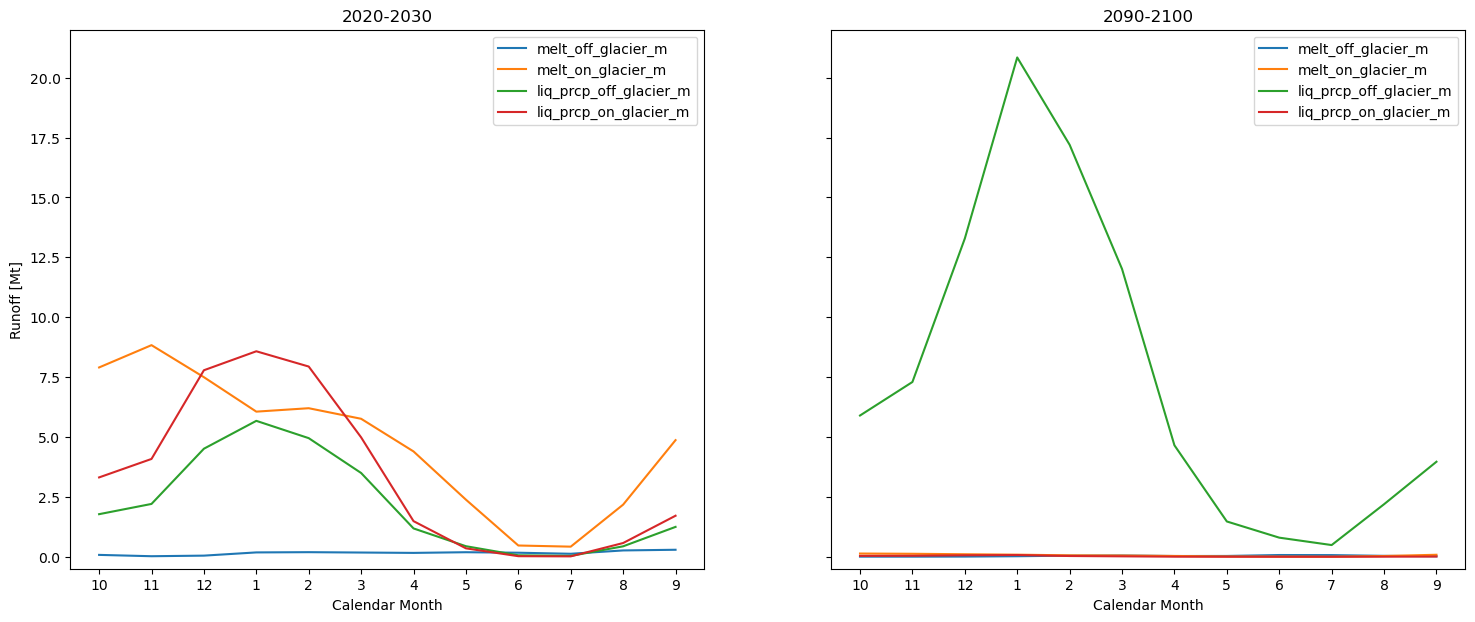

In [120]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s85.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s85, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e85, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)
    
ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

plt.ylim([-0.5,22]);

# Step 3: multi-GCM visualizations

## Visualize time slices!

In [121]:
key_dict = {}

key_dict['rcp26'] = season_unroll26.keys()
key_dict['rcp45'] = season_unroll45.keys()
key_dict['rcp60'] = season_unroll60.keys()
key_dict['rcp85'] = season_unroll85.keys()

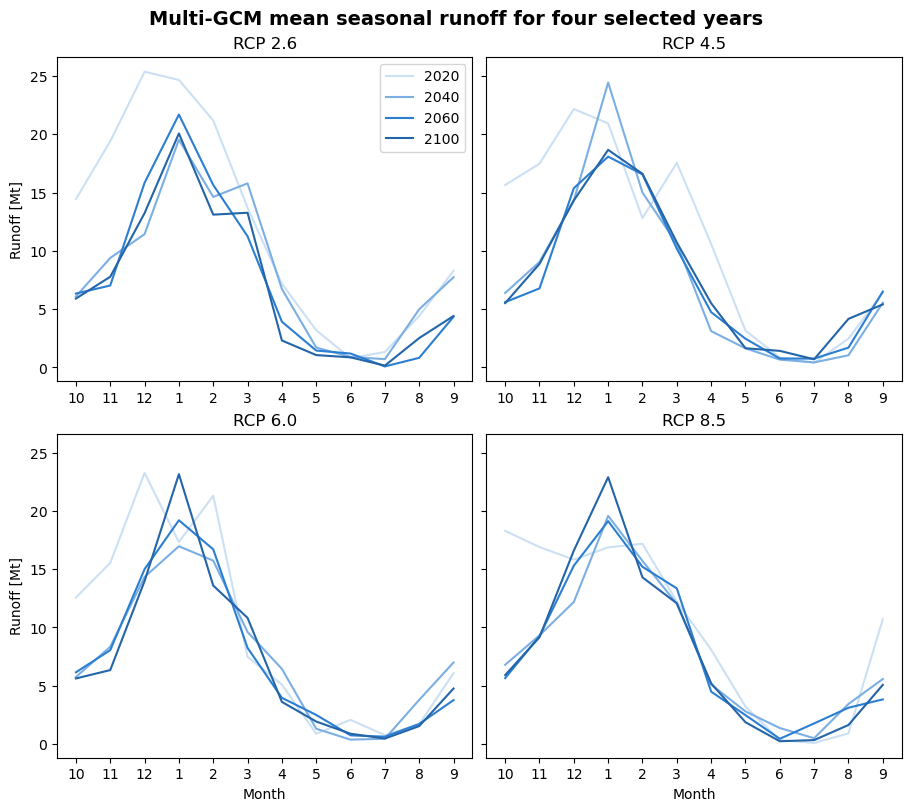

In [122]:
# Let's try to get this to show each GCM as well as means!
time = [0, 20, 40, 80]

color_ts = ('#cce0f4', '#7bafe3', '#2b7ed1', '#2365a8')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 8), sharey=True, constrained_layout = True)       

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['rcp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax1.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['rcp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax2.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['rcp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax3.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1
    
t_idx=0
for t in time:
    season_t = season_sliced(key_dict['rcp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax4.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

ax1.set(xticks = season_roll['month_2d'].values,
        xticklabels = season_roll2['month_2d'].values,
        title = 'RCP 2.6',
        ylabel = 'Runoff [Mt]');
ax2.set(xticks = season_roll['month_2d'].values,
        xticklabels = season_roll2['month_2d'].values,
        title = 'RCP 4.5');
ax3.set(xticks = season_roll['month_2d'].values,
        ylabel = 'Runoff [Mt]',
        xticklabels = season_roll2['month_2d'].values,
        title = 'RCP 6.0',
        xlabel = 'Month');
ax4.set(xticks = season_roll['month_2d'].values,
        xticklabels = season_roll2['month_2d'].values,
        title = 'RCP 8.5',
        xlabel = 'Month');
ax1.legend();

plt.suptitle('Multi-GCM mean seasonal runoff for four selected years', fontweight = 'bold', fontsize = 14);

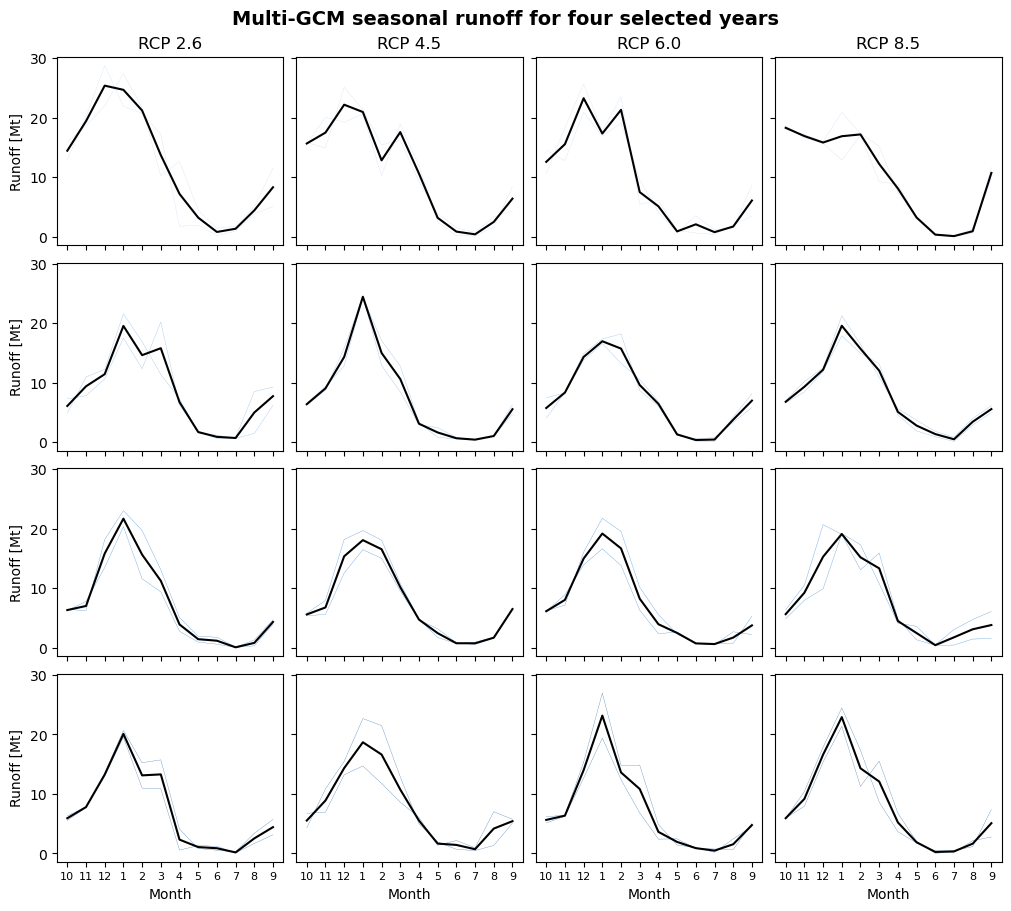

In [123]:
time = [0, 20, 40, 80]

from matplotlib import cm
#color_ts = ('#c2f2f2', '#81cfdb', '#4c858f', '#23393d')
#New colors 5/4/23
color_ts = ('#cce0f4', '#7bafe3', '#2b7ed1', '#2365a8')

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, figsize=(10, 9), sharex=True, sharey=True, constrained_layout = True)

# Make first row of RCPs for time t=0
t = time[0]
for k in season_unroll26.keys():
    color_idx = 0
    season_t = season_sliced(key_dict['rcp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax1.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.8)
ax1.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll45.keys():
    color_idx = 0
    season_t = season_sliced(key_dict['rcp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax2.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.8)
ax2.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll60.keys():
    color_idx = 0
    season_t = season_sliced(key_dict['rcp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax3.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.8)
ax3.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll85.keys():
    color_idx = 0
    season_t = season_sliced(key_dict['rcp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax4.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.8)
ax4.plot(xvals, season_t['mean'], color='k', linewidth=1.5)


# Make second row of RCPs for time t=20
t = time[1]
for k in season_unroll26.keys():
    color_idx = 1
    season_t = season_sliced(key_dict['rcp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax5.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax5.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll45.keys():
    color_idx = 1
    season_t = season_sliced(key_dict['rcp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax6.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax6.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll60.keys():
    color_idx = 1
    season_t = season_sliced(key_dict['rcp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax7.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax7.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll85.keys():
    color_idx = 1
    season_t = season_sliced(key_dict['rcp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax8.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax8.plot(xvals, season_t['mean'], color='k', linewidth=1.5)


# Make third row of RCPs for time t=40
t = time[2]
for k in season_unroll26.keys():
    color_idx = 2
    season_t = season_sliced(key_dict['rcp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax9.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax9.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll45.keys():
    color_idx = 2
    season_t = season_sliced(key_dict['rcp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax10.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax10.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll60.keys():
    color_idx = 2
    season_t = season_sliced(key_dict['rcp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax11.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax11.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll85.keys():
    color_idx = 2
    season_t = season_sliced(key_dict['rcp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax12.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax12.plot(xvals, season_t['mean'], color='k', linewidth=1.5)


# Make fourth row of RCPs for time t=80
t = time[3]
for k in season_unroll26.keys():
    color_idx = 3
    season_t = season_sliced(key_dict['rcp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax13.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax13.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll45.keys():
    color_idx = 3
    season_t = season_sliced(key_dict['rcp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax14.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax14.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll60.keys():
    color_idx = 3
    season_t = season_sliced(key_dict['rcp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax15.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax15.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll85.keys():
    color_idx = 3
    season_t = season_sliced(key_dict['rcp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax16.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax16.plot(xvals, season_t['mean'], color='k', linewidth=1.5)
    
ax1.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'RCP 2.6');
ax2.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'RCP 4.5');
ax3.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'RCP 6.0');
ax4.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'RCP 8.5');

ax1.set(ylabel = 'Runoff [Mt]')
ax5.set(ylabel = 'Runoff [Mt]')
ax9.set(ylabel = 'Runoff [Mt]')
ax13.set(ylabel = 'Runoff [Mt]',
        xlabel = 'Month')
ax14.set(xlabel = 'Month')
ax15.set(xlabel = 'Month')
ax16.set(xlabel = 'Month')

ax13.tick_params(axis='x', which='major', labelsize=8)
ax14.tick_params(axis='x', which='major', labelsize=8)
ax15.tick_params(axis='x', which='major', labelsize=8)
ax16.tick_params(axis='x', which='major', labelsize=8)

plt.suptitle('Multi-GCM seasonal runoff for four selected years', fontweight = 'bold', fontsize = 14);

#plt.savefig('Figures/Seasonal/Slice/all_rcps_all_GCMs_16mega_may4', bbox_inches='tight')

## Compiled decadal runoff by RCP

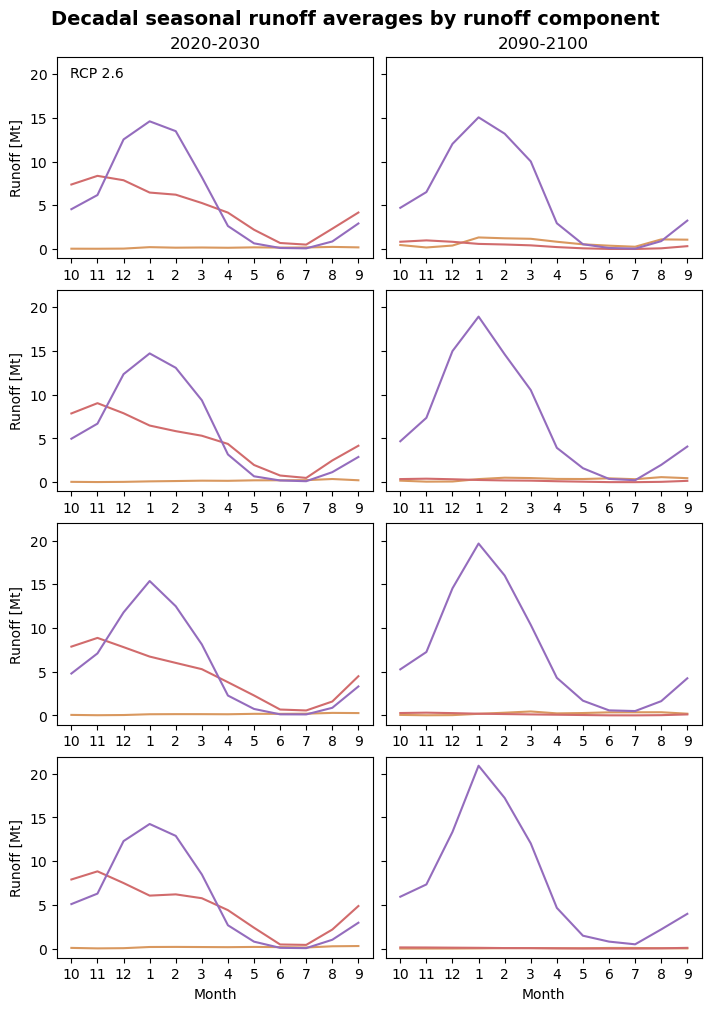

In [124]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m']
sum_vars = ['liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(7, 10), sharey=True, constrained_layout=True)

color_pr = '#946cbd'
color_m = ('#d9985f', '#d16b6c')

s_keys = rtype_calc_s26.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s26, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e26, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax2.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s26, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e26, sum_vars[0], sum_vars[1])
xvals = index2
ax1.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax2.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

s_keys = rtype_calc_s45.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s45, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e45, r)
    xvals = index2
    ax3.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax4.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s45, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e45, sum_vars[0], sum_vars[1])
xvals = index2
ax3.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax4.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

s_keys = rtype_calc_s60.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s60, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e60, r)
    xvals = index2
    ax5.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax6.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s60, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e60, sum_vars[0], sum_vars[1])
xvals = index2
ax5.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax6.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

s_keys = rtype_calc_s85.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s85, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e85, r)
    xvals = index2
    ax7.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax8.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s85, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e85, sum_vars[0], sum_vars[1])
xvals = index2
ax7.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax8.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

ax1.set(ylabel='Runoff [Mt]', title='2020-2030') # this title and the next one are overwritten by my addition
ax2.set(title='2090-2100')
ax3.set(ylabel='Runoff [Mt]')
ax5.set(ylabel='Runoff [Mt]')
ax7.set(ylabel='Runoff [Mt]', xlabel='Month')
ax8.set(xlabel='Month')

# THIS WORKS
for ax in (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8):
    ax.set(xticks=season_roll['month_2d'].values,
           xticklabels=season_roll2['month_2d'].values,  # here, we want calendar year values
           )

# Add RCP labels as titles (from chatgpt)
# ax1.set_title('RCP 2.6: 2020-2030', fontsize=10)
# ax2.set_title('RCP 2.6: 2090-2100', fontsize=10)
# ax3.set_title('RCP 4.5: 2020-2030', fontsize=10)
# ax4.set_title('RCP 4.5: 2090-2100', fontsize=10)
# ax5.set_title('RCP 6.0: 2020-2030', fontsize=10)
# ax6.set_title('RCP 6.0: 2090-2100', fontsize=10)
# ax7.set_title('RCP 8.5: 2020-2030', fontsize=10)
# ax8.set_title('RCP 8.5: 2090-2100', fontsize=10)

ax1.text(0.04, 0.9, 'RCP 2.6', transform=ax1.transAxes)

plt.suptitle('Decadal seasonal runoff averages by runoff component', fontweight='bold', fontsize=14)

plt.show()


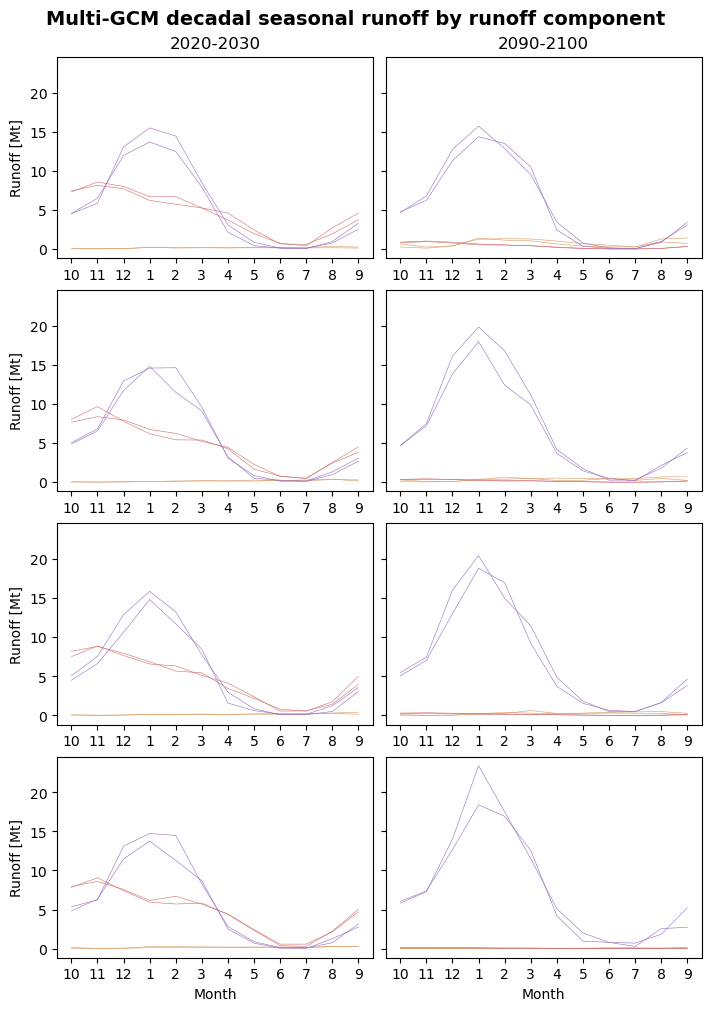

In [125]:
# Visualize seasonal runoff by component for each GCM
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m']
sum_vars = ['liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(7, 10), sharey=True, constrained_layout = True);

color_pr = '#946cbd'
color_m = ('#d9985f', '#d16b6c')

# RCP2.6
s_keys = rtype_calc_s26.keys()
ct=0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s26, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e26, r)
    xvals = index2
    for g in s_keys:
        ax1.plot(xvals, runoff_s[g], color=color_m[ct], linewidth=0.4)
        ax2.plot(xvals, runoff_e[g], color=color_m[ct], linewidth=0.4)
    ct=ct+1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s26, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e26, sum_vars[0], sum_vars[1])
for g in s_keys:
    ax1.plot(xvals, runoff_s[g], color=color_pr, linewidth=0.4)
    ax2.plot(xvals, runoff_e[g], color=color_pr, linewidth=0.4)
    

# RCP4.5
s_keys = rtype_calc_s45.keys()
ct=0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s45, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e45, r)
    xvals = index2
    for g in s_keys:
        ax3.plot(xvals, runoff_s[g], color=color_m[ct], linewidth=0.4)
        ax4.plot(xvals, runoff_e[g], color=color_m[ct], linewidth=0.4)
    ct=ct+1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s45, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e45, sum_vars[0], sum_vars[1])
for g in s_keys:
    ax3.plot(xvals, runoff_s[g], color=color_pr, linewidth=0.4)
    ax4.plot(xvals, runoff_e[g], color=color_pr, linewidth=0.4)


# RCP6.0
s_keys = rtype_calc_s60.keys()
ct=0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s60, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e60, r)
    xvals = index2
    for g in s_keys:
        ax5.plot(xvals, runoff_s[g], color=color_m[ct], linewidth=0.4)
        ax6.plot(xvals, runoff_e[g], color=color_m[ct], linewidth=0.4)
    ct=ct+1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s60, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e60, sum_vars[0], sum_vars[1])
for g in s_keys:
    ax5.plot(xvals, runoff_s[g], color=color_pr, linewidth=0.4)
    ax6.plot(xvals, runoff_e[g], color=color_pr, linewidth=0.4)

# RCP8.5
s_keys = rtype_calc_s85.keys()
ct=0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s85, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e85, r)
    xvals = index2
    for g in s_keys:
        ax7.plot(xvals, runoff_s[g], color=color_m[ct], linewidth=0.4)
        ax8.plot(xvals, runoff_e[g], color=color_m[ct], linewidth=0.4)
    ct=ct+1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s85, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e85, sum_vars[0], sum_vars[1])
for g in s_keys:
    ax7.plot(xvals, runoff_s[g], color=color_pr, linewidth=0.4)
    ax8.plot(xvals, runoff_e[g], color=color_pr, linewidth=0.4)
    

ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
ax3.set(ylabel='Runoff [Mt]')
ax5.set(ylabel='Runoff [Mt]')
ax7.set(ylabel='Runoff [Mt]', xlabel = 'Month')
ax8.set(xlabel = 'Month')
# THIS WORKS
for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
          );

plt.suptitle('Multi-GCM decadal seasonal runoff by runoff component', fontweight = 'bold', fontsize = 14);

#plt.savefig('Figures/Seasonal/Decade_av/4x2_seasonsall_rcps_allgcms.png', bbox_inches='tight')

### Plot of relative contribution on decade scale

In [126]:
# Set up the dictionaries with values to use in the summing function
s_keys_dict = {}
s_keys_dict['rcp26'] = rtype_calc_s26.keys()
s_keys_dict['rcp45'] = rtype_calc_s45.keys()
s_keys_dict['rcp60'] = rtype_calc_s60.keys()
s_keys_dict['rcp85'] = rtype_calc_s85.keys()

rtype_calc_dict_s = {}
rtype_calc_dict_s['rcp26'] = rtype_calc_s26
rtype_calc_dict_s['rcp45'] = rtype_calc_s45
rtype_calc_dict_s['rcp60'] = rtype_calc_s60
rtype_calc_dict_s['rcp85'] = rtype_calc_s85

rtype_calc_dict_e = {}
rtype_calc_dict_e['rcp26'] = rtype_calc_e26
rtype_calc_dict_e['rcp45'] = rtype_calc_e45
rtype_calc_dict_e['rcp60'] = rtype_calc_e60
rtype_calc_dict_e['rcp85'] = rtype_calc_e85

In [127]:
rcp = ('rcp26', 'rcp45', 'rcp60', 'rcp85')

all_rcp_dict_s = {}

for r in rcp:
    melt_on = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_s[r], 'melt_on_glacier_m')
    melt_off = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_s[r], 'melt_off_glacier_m')
    liq = rtype_calc_monthly_2vars(s_keys_dict[r], rtype_calc_dict_s[r], 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m')
    summed = melt_on + melt_off + liq
    m_on_name = 'm-on-{}'.format(r)
    m_off_name = 'm-off-{}'.format(r)
    liq_name = 'liq-{}'.format(r)
    sum_name = 'sum-{}'.format(r)
    all_rcp_dict_s[m_on_name] = melt_on
    all_rcp_dict_s[m_off_name] = melt_off
    all_rcp_dict_s[liq_name] = liq
    all_rcp_dict_s[sum_name] = summed

all_rcp_dict_e = {}

for r in rcp:
    melt_on = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_e[r], 'melt_on_glacier_m')
    melt_off = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_e[r], 'melt_off_glacier_m')
    liq = rtype_calc_monthly_2vars(s_keys_dict[r], rtype_calc_dict_e[r], 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m')
    summed = melt_on + melt_off + liq
    m_on_name = 'm-on-{}'.format(r)
    m_off_name = 'm-off-{}'.format(r)
    liq_name = 'liq-{}'.format(r)
    sum_name = 'sum-{}'.format(r)
    all_rcp_dict_e[m_on_name] = melt_on
    all_rcp_dict_e[m_off_name] = melt_off
    all_rcp_dict_e[liq_name] = liq
    all_rcp_dict_e[sum_name] = summed

Text(0.5, 1.0, 'RCP 8.5: 2090-2100')

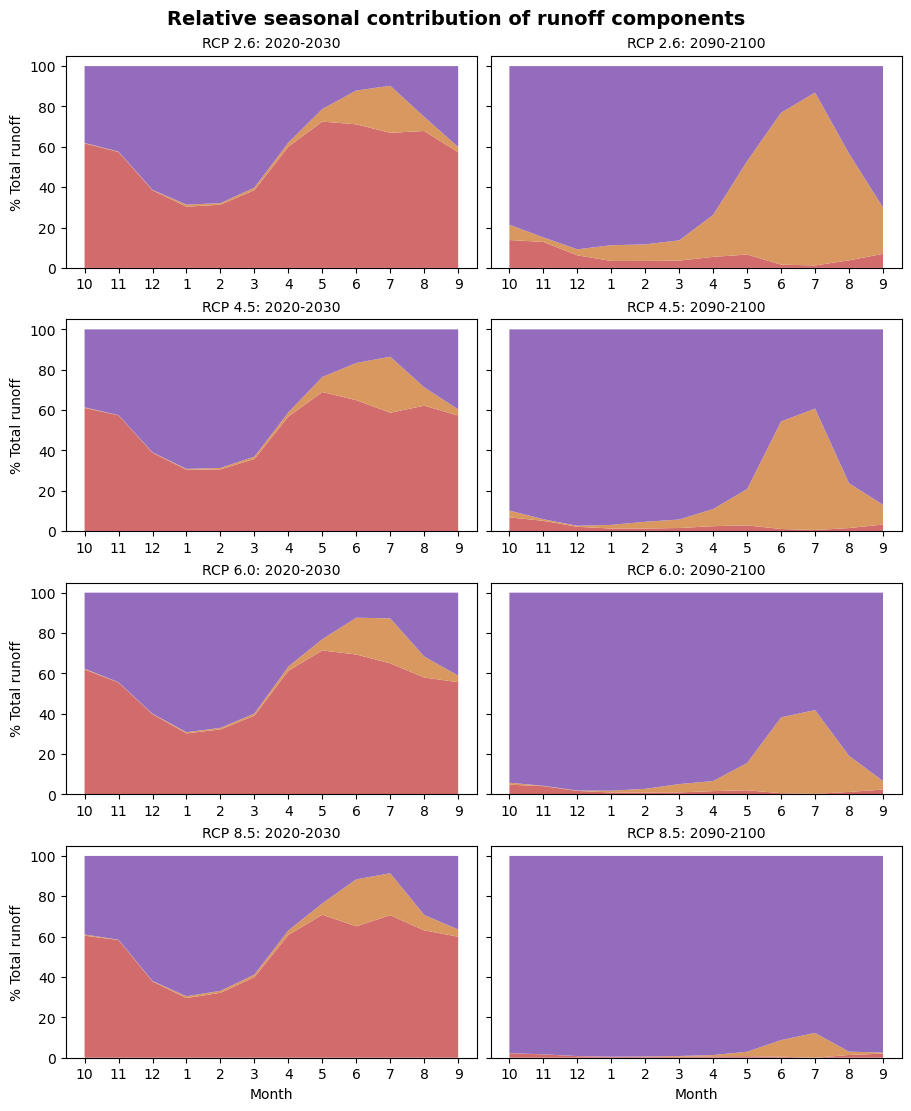

In [128]:
# Graph of relative importance of runoff for each part of the seasonal cycle (decade 1 and last)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(9, 11), sharey=True, constrained_layout = True);

color_pr = '#946cbd'
color_m = ('#d9985f', '#d16b6c')

xvals = index2

# RCP 2.6
rcp_key = 'rcp26'
ax1.stackplot(xvals, all_rcp_dict_s['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_s['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_s['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax2.stackplot(xvals, all_rcp_dict_e['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_e['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_e['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# RCP4.5
rcp_key = 'rcp45'
ax3.stackplot(xvals, all_rcp_dict_s['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_s['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_s['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax4.stackplot(xvals, all_rcp_dict_e['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_e['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_e['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# RCP6.0
rcp_key = 'rcp60'
ax5.stackplot(xvals, all_rcp_dict_s['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_s['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_s['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax6.stackplot(xvals, all_rcp_dict_e['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_e['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_e['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# RCP85
rcp_key = 'rcp85'
ax7.stackplot(xvals, all_rcp_dict_s['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_s['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_s['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax8.stackplot(xvals, all_rcp_dict_e['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_e['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_e['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

#ax1.legend(bbox_to_anchor=(0.44, 0.95));

plt.suptitle('Relative seasonal contribution of runoff components', fontweight = 'bold', fontsize = 14);

ax1.set(ylabel='% Total runoff', title='2020-2030')
ax2.set(title='2090-2100')
ax3.set(ylabel='% Total runoff')
ax5.set(ylabel='% Total runoff')
ax7.set(ylabel='% Total runoff', xlabel = 'Month')
ax8.set(xlabel = 'Month')
# THIS WORKS
for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values #here, we want calendar year values
          );
# Add RCP labels as titles (from chatgpt)
ax1.set_title('RCP 2.6: 2020-2030', fontsize=10)
ax2.set_title('RCP 2.6: 2090-2100', fontsize=10)
ax3.set_title('RCP 4.5: 2020-2030', fontsize=10)
ax4.set_title('RCP 4.5: 2090-2100', fontsize=10)
ax5.set_title('RCP 6.0: 2020-2030', fontsize=10)
ax6.set_title('RCP 6.0: 2090-2100', fontsize=10)
ax7.set_title('RCP 8.5: 2020-2030', fontsize=10)
ax8.set_title('RCP 8.5: 2090-2100', fontsize=10)

#plt.savefig('Figures/Seasonal/Decade_av/4x2_relative_importance_newMay4.png', bbox_inches='tight')

# Step 4: plot annual runoff

In [235]:
import xarray as xr

# Function to calculate annual runoff
def calc_annual_runoff(data_array):
    # Sum over the month_2d dimension to get annual data
    annual_sum = data_array.sum(dim='month_2d')
    return annual_sum

# Dictionary to store annual runoff for each GCM and RCP scenario
annual_runoff_dict = {}

# List of scenarios
scenarios = ['NorESM1-M-rcp26-calc', 'CCSM4-rcp26-calc']

for scenario in scenarios:
    if scenario in season_unroll26:
        data_array = season_unroll26[scenario]
        annual_runoff = calc_annual_runoff(data_array)
        annual_runoff_dict[scenario] = annual_runoff
    else:
        print(f"Scenario '{scenario}' not found in season_unroll26")


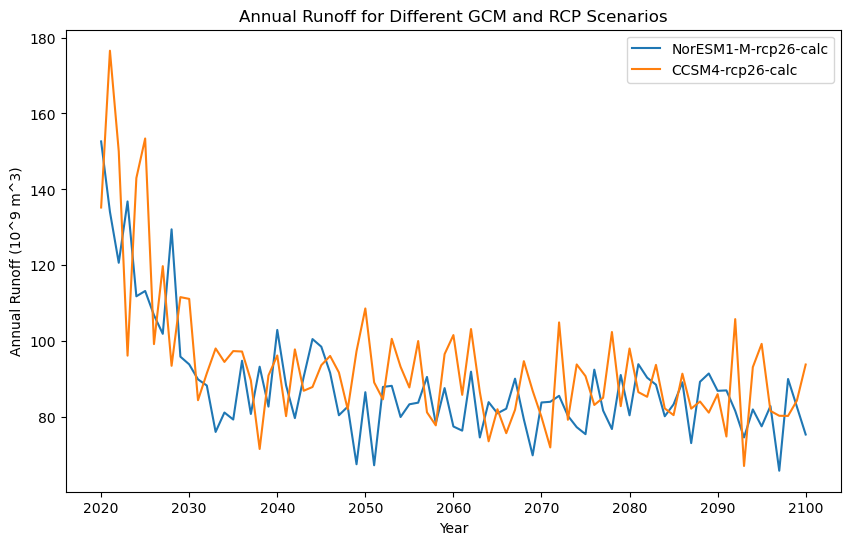

In [236]:
import matplotlib.pyplot as plt

# Function to plot annual runoff
def plot_annual_runoff(annual_runoff_dict):
    plt.figure(figsize=(10, 6))

    for scenario, annual_runoff in annual_runoff_dict.items():
        years = annual_runoff['time'].values
        runoff_values = annual_runoff.values
        plt.plot(years, runoff_values, label=scenario)
    
    plt.xlabel('Year')
    plt.ylabel('Annual Runoff (10^9 m^3)')
    plt.title('Annual Runoff for Different GCM and RCP Scenarios')
    plt.legend()
    plt.show()

# Call the plotting function
plot_annual_runoff(annual_runoff_dict)


In [217]:
import xarray as xr

# Function to calculate annual runoff
def calc_annual_runoff(data_array):
    # Sum over the month_2d dimension to get annual data
    annual_sum = data_array.sum(dim='month_2d')
    return annual_sum

# Dictionary to store annual runoff for each GCM and RCP scenario
annual_runoff_dict = {}

# List of scenarios and datasets
scenarios_datasets = {
    'NorESM1-M-rcp26-calc': season_unroll26['NorESM1-M-rcp26-calc'],
    'CCSM4-rcp26-calc': season_unroll26['CCSM4-rcp26-calc'],
    'NorESM1-M-rcp45-calc': season_unroll45['NorESM1-M-rcp45-calc'],
    'CCSM4-rcp45-calc': season_unroll45['CCSM4-rcp45-calc'],
    'NorESM1-M-rcp60-calc': season_unroll60['NorESM1-M-rcp60-calc'],
    'CCSM4-rcp60-calc': season_unroll60['CCSM4-rcp60-calc'],
    'NorESM1-M-rcp85-calc': season_unroll85['NorESM1-M-rcp85-calc'],
    'CCSM4-rcp85-calc': season_unroll85['CCSM4-rcp85-calc']
}

for scenario, data_array in scenarios_datasets.items():
    annual_runoff = calc_annual_runoff(data_array)
    annual_runoff_dict[scenario] = annual_runoff

#look at the data array for annual runoff?

In [252]:
print(annual_runoff)

<xarray.DataArray (time: 81)> Size: 324B
array([135.23228 , 176.52538 , 150.04248 ,  96.211975, 142.99205 ,
       153.4084  ,  99.255196, 119.787155,  93.5426  , 111.628815,
       111.16698 ,  84.478386,  91.56242 ,  98.1055  ,  94.562515,
        97.416794,  97.30427 ,  89.72765 ,  71.63855 ,  90.99266 ,
        96.26152 ,  80.28293 ,  97.86905 ,  86.9695  ,  87.9562  ,
        93.69833 ,  96.14109 ,  91.78595 ,  82.08695 ,  97.40123 ,
       108.64124 ,  89.166695,  84.71494 , 100.6502  ,  93.29262 ,
        87.837555, 100.05915 ,  81.29383 ,  77.853745,  96.61577 ,
       101.63194 ,  85.89003 , 103.21868 ,  86.65958 ,  73.654   ,
        82.10542 ,  75.79376 ,  81.968864,  94.76044 ,  86.96045 ,
        80.07391 ,  72.03644 , 104.97077 ,  79.32887 ,  93.89686 ,
        90.818054,  83.22837 ,  85.12877 , 102.43619 ,  82.91248 ,
        98.10275 ,  86.61061 ,  85.37889 ,  93.78948 ,  82.32077 ,
        80.547516,  91.46609 ,  82.256485,  84.13735 ,  81.208595,
        86.08173 ,  7

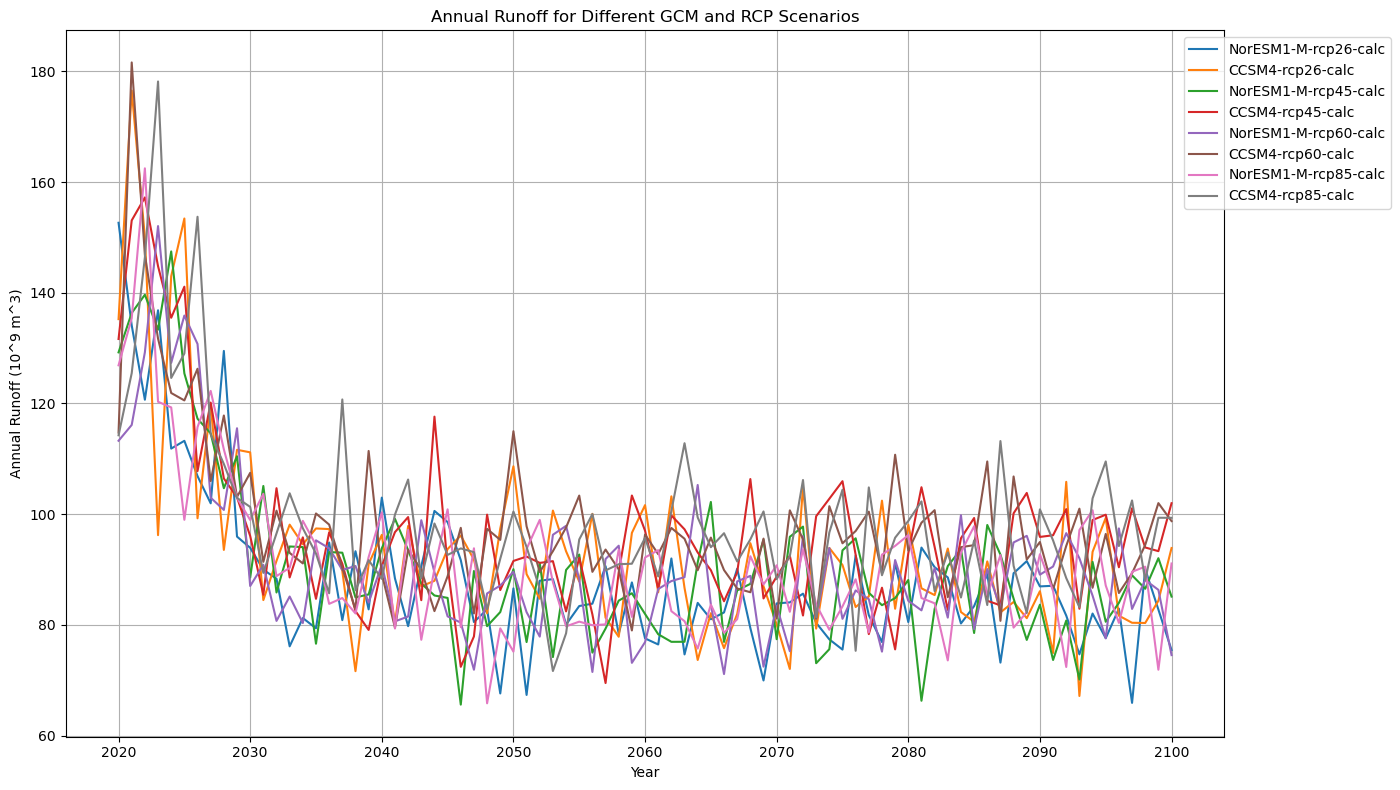

In [218]:
import matplotlib.pyplot as plt

# Function to plot annual runoff
def plot_annual_runoff(annual_runoff_dict):
    plt.figure(figsize=(14, 8))

    for scenario, annual_runoff in annual_runoff_dict.items():
        years = annual_runoff['time'].values
        runoff_values = annual_runoff.values
        plt.plot(years, runoff_values, label=scenario)
    
    plt.xlabel('Year')
    plt.ylabel('Annual Runoff (10^9 m^3)')
    plt.title('Annual Runoff for Different GCM and RCP Scenarios')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_annual_runoff(annual_runoff_dict)


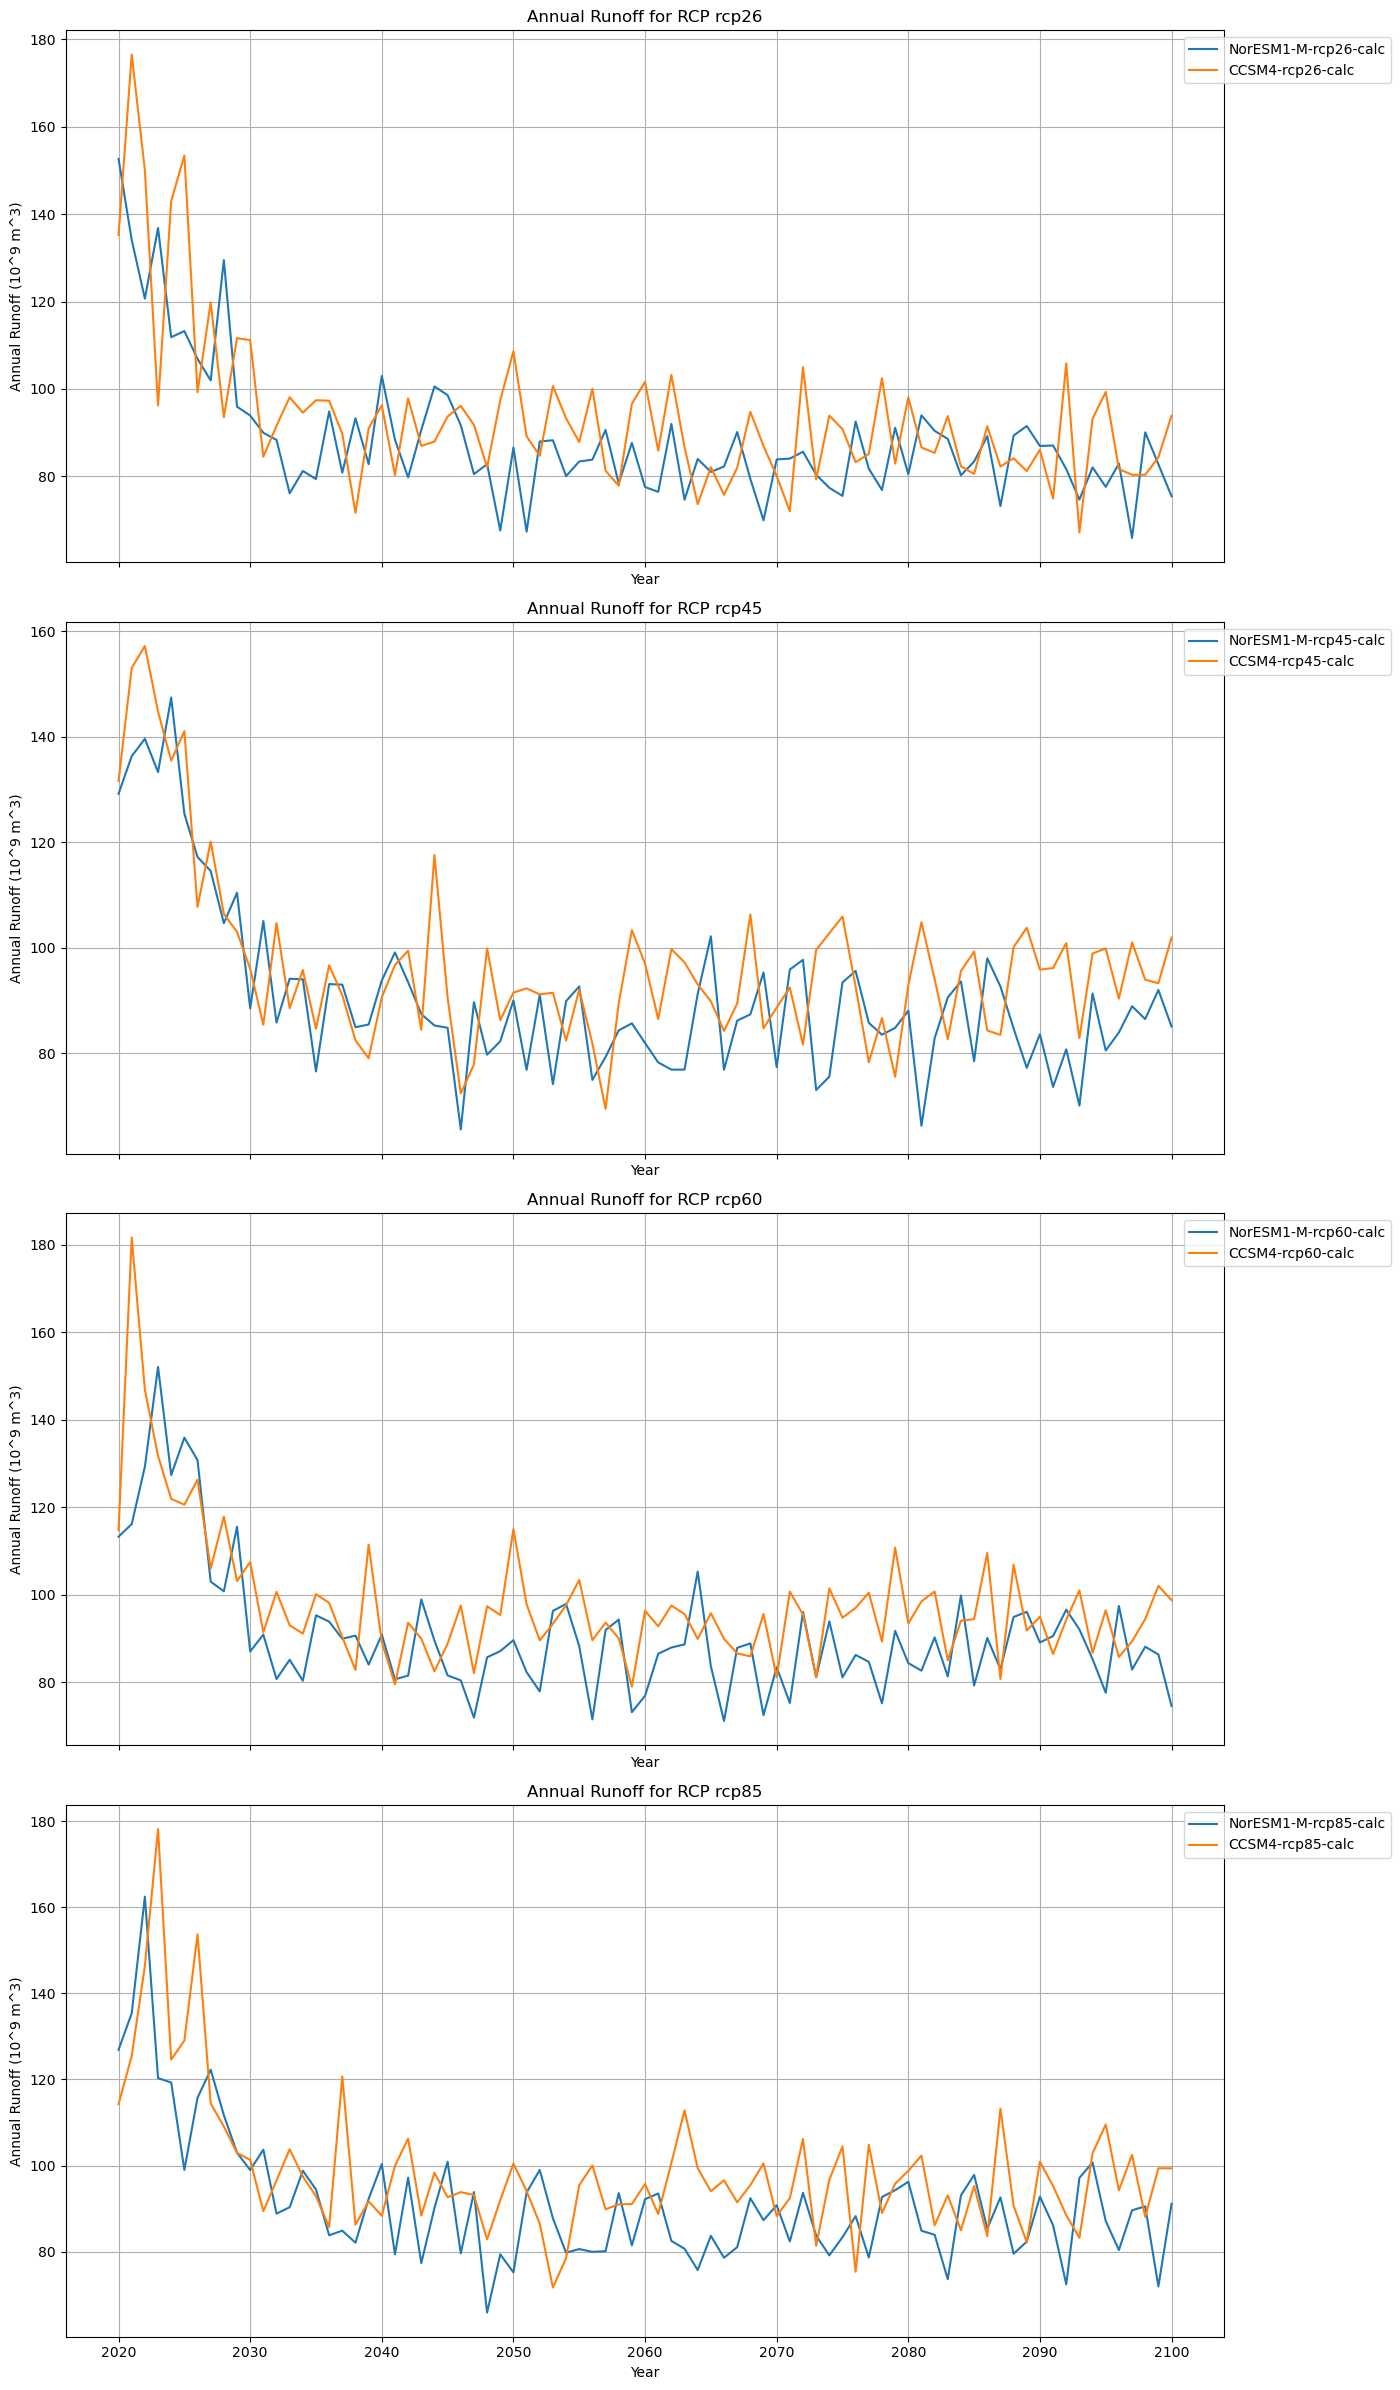

In [253]:
import xarray as xr
import matplotlib.pyplot as plt

# Function to calculate annual runoff
def calc_annual_runoff(data_array):
    # Sum over the month_2d dimension to get annual data
    annual_sum = data_array.sum(dim='month_2d')
    return annual_sum

# Dictionary to store annual runoff for each GCM and RCP scenario
annual_runoff_dict = {}

# List of scenarios and datasets
scenarios_datasets = {
    'NorESM1-M-rcp26-calc': season_unroll26['NorESM1-M-rcp26-calc'],
    'CCSM4-rcp26-calc': season_unroll26['CCSM4-rcp26-calc'],
    'NorESM1-M-rcp45-calc': season_unroll45['NorESM1-M-rcp45-calc'],
    'CCSM4-rcp45-calc': season_unroll45['CCSM4-rcp45-calc'],
    'NorESM1-M-rcp60-calc': season_unroll60['NorESM1-M-rcp60-calc'],
    'CCSM4-rcp60-calc': season_unroll60['CCSM4-rcp60-calc'],
    'NorESM1-M-rcp85-calc': season_unroll85['NorESM1-M-rcp85-calc'],
    'CCSM4-rcp85-calc': season_unroll85['CCSM4-rcp85-calc']
}

# Calculate annual runoff for each scenario
for scenario, data_array in scenarios_datasets.items():
    annual_runoff = calc_annual_runoff(data_array)
    annual_runoff_dict[scenario] = annual_runoff

# List of RCP scenarios
rcps = ['rcp26', 'rcp45', 'rcp60', 'rcp85']

# Function to plot annual runoff for each RCP scenario
def plot_rcp_separate(annual_runoff_dict, rcps):
    fig, axes = plt.subplots(len(rcps), 1, figsize=(14, 24), sharex=True)
    
    for i, rcp in enumerate(rcps):
        ax = axes[i]
        ax.set_title(f'Annual Runoff for RCP {rcp}')
        
        for scenario, annual_runoff in annual_runoff_dict.items():
            if rcp in scenario:
                years = annual_runoff['time'].values
                runoff_values = annual_runoff.values
                ax.plot(years, runoff_values, label=scenario)
        
        ax.set_xlabel('Year')
        ax.set_ylabel('Annual Runoff (10^9 m^3)')
        ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_rcp_separate(annual_runoff_dict, rcps)


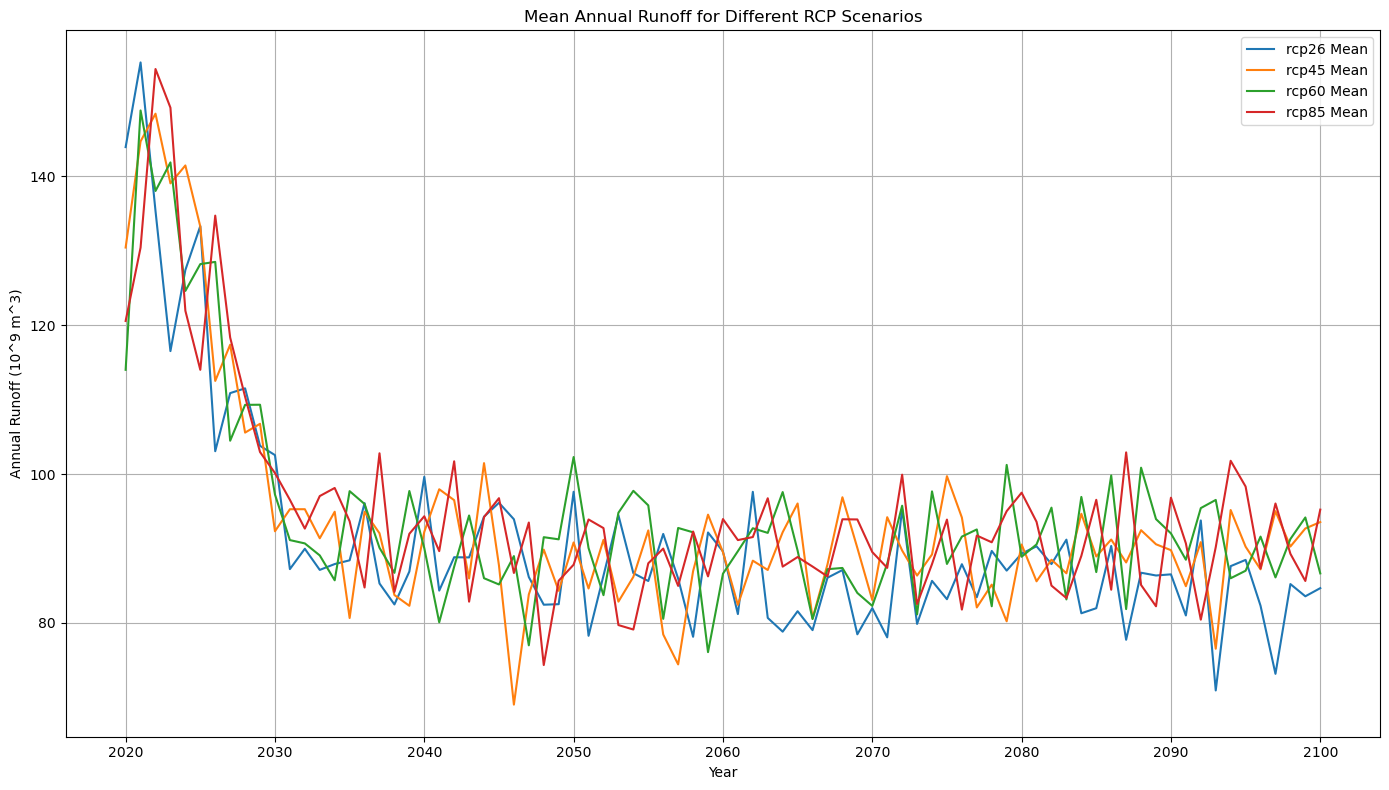

In [268]:
import xarray as xr
import matplotlib.pyplot as plt

# Function to calculate annual runoff
def calc_annual_runoff(data_array):
    # Sum over the month_2d dimension to get annual data
    annual_sum = data_array.sum(dim='month_2d')
    return annual_sum

# Function to calculate the mean annual runoff across GCMs for each RCP scenario
def calculate_mean_annual_runoff(annual_runoff_dict, rcps):
    mean_annual_runoff = {}
    for rcp in rcps:
        rcp_data = [annual_runoff for scenario, annual_runoff in annual_runoff_dict.items() if rcp in scenario]
        if rcp_data:
            combined = xr.concat(rcp_data, dim='gcm')
            mean_annual_runoff[rcp] = combined.mean(dim='gcm')
    return mean_annual_runoff

# Function to plot the mean annual runoff for each RCP scenario on one plot
def plot_mean_annual_runoff(mean_annual_runoff):
    plt.figure(figsize=(14, 8))

    for rcp, annual_runoff in mean_annual_runoff.items():
        years = annual_runoff['time'].values
        runoff_values = annual_runoff.values
        plt.plot(years, runoff_values, label=f'{rcp} Mean')
    
    plt.xlabel('Year')
    plt.ylabel('Annual Runoff (10^9 m^3)')
    plt.title('Mean Annual Runoff for Different RCP Scenarios')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Dictionary to store annual runoff for each GCM and RCP scenario
annual_runoff_dict = {
    'NorESM1-M-rcp26-calc': calc_annual_runoff(season_unroll26['NorESM1-M-rcp26-calc']),
    'CCSM4-rcp26-calc': calc_annual_runoff(season_unroll26['CCSM4-rcp26-calc']),
    'NorESM1-M-rcp45-calc': calc_annual_runoff(season_unroll45['NorESM1-M-rcp45-calc']),
    'CCSM4-rcp45-calc': calc_annual_runoff(season_unroll45['CCSM4-rcp45-calc']),
    'NorESM1-M-rcp60-calc': calc_annual_runoff(season_unroll60['NorESM1-M-rcp60-calc']),
    'CCSM4-rcp60-calc': calc_annual_runoff(season_unroll60['CCSM4-rcp60-calc']),
    'NorESM1-M-rcp85-calc': calc_annual_runoff(season_unroll85['NorESM1-M-rcp85-calc']),
    'CCSM4-rcp85-calc': calc_annual_runoff(season_unroll85['CCSM4-rcp85-calc'])
}

# List of RCP scenarios
rcps = ['rcp26', 'rcp45', 'rcp60', 'rcp85']

# Calculate the mean annual runoff for each RCP scenario
mean_annual_runoff = calculate_mean_annual_runoff(annual_runoff_dict, rcps)

# Call the plotting function
plot_mean_annual_runoff(mean_annual_runoff)